# Kupffer Analysis Data Processing

In [1]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import pandas as pd
import numpy as np
import matplotlib
import threading
import matplotlib.pyplot as plt 
import seaborn as sns
from collections import Counter
matplotlib.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
import pickle
from sklearn import preprocessing
import time
import inspect
sns.set_context('talk')

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df

# Define Functions

## Sequence extraction

In [2]:
def read_bed_file(input_path):
    '''
    reads a bed file and returns the genomic coordinates
    '''
    with open(input_path) as f:
        data = f.readlines()
    coordinates = []
    if data[0].strip()[0] == '#':
        data = data[1:]
    for line in data:
        tokens = line.strip().split()
        chrom = tokens[0]
        start = tokens[1]
        end = tokens[2]
        coordinates.append((chrom,start, end))
    return coordinates

def extract_sequence(coordinates, genome, out_file_path):
    '''
    Given a list of genomic coordinates, extracts sequences
    inputs: [(chrom1, start1, end1), ..., (chromN, startN, endN)]
    outputs: [seq1, seq2, ...seqN]
    '''
    script_path = '/home/h1bennet/code/tba/model_training/'
    if genome == 'mm10':
        genome_path = script_path + '/mm10/'
        chromosomes = ['chr1' , 'chr2' , 'chr3' , 'chr4' , 'chr5' ,
                        'chr6' , 'chr7' , 'chr8' , 'chr9' , 'chr10',
                        'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
                        'chr16', 'chr17', 'chr18', 'chr19', 'chrX']
    elif genome == 'hg38':
        genome_path = script_path + '/hg38/'
        chromosomes = ['chr1' , 'chr2' , 'chr3' , 'chr4' , 'chr5' ,
                        'chr6' , 'chr7' , 'chr8' , 'chr9' , 'chr10',
                        'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
                        'chr16', 'chr17', 'chr18', 'chr19', 'chr20',
                        'chr21', 'chr22', 'chrX']
    
    chrom_size_dict = {}
    chrom_seq_dict = {}
    
    chrom_size_dict = {}
    chrom_seq_dict = {}

    print('reading genome', genome)
    for chrom in chromosomes:
        with open(genome_path + chrom + '.fa') as f:
            data = f.readlines()
        seq = ''.join(x.upper().strip() for x in data[1:])
        size = len(seq)
        chrom_size_dict[chrom] = size
        chrom_seq_dict[chrom] = seq

    out_file = open(out_file_path, 'w')
    for coord in coordinates:
        chrom = coord[0]
        # chrom_seq dict is 0 indexed, genome coords are 1 indexed
        start = int(coord[1]) - 1
        end = int(coord[2]) - 1
        if chrom in chrom_seq_dict:
            seq = chrom_seq_dict[chrom][start:end]
            id_line = '>' + str(coord[0]) + ':' +str(coord[1]) + '-' + str(coord[2]) + '\n'
            out_file.write(id_line)
            out_file.write(seq + '\n')
    out_file.close()
    

def read_bed_file_with_id(input_path):
    '''
    reads a bed file and returns the genomic coordinates
    '''
    with open(input_path) as f:
        data = f.readlines()
    coordinates = []
    if data[0].strip()[0] == '#':
        data = data[1:]
    for line in data:
        tokens = line.strip().split()
        chrom = tokens[0]
        start = tokens[1]
        end = tokens[2]
        ident = tokens[3]
        coordinates.append((chrom,start, end, ident))
    return coordinates
    
def extract_sequence_with_id(coordinates, genome, out_file_path):
    '''
    Given a list of genomic coordinates, extracts sequences
    inputs: [(chrom1, start1, end1), ..., (chromN, startN, endN)]
    outputs: [seq1, seq2, ...seqN]
    '''
    
    script_path = '/home/h1bennet/code/abtba/model_training/'
    if genome == 'mm10':
        genome_path = script_path + '/mm10/'
        chromosomes = ['chr1' , 'chr2' , 'chr3' , 'chr4' , 'chr5' ,
                        'chr6' , 'chr7' , 'chr8' , 'chr9' , 'chr10',
                        'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
                        'chr16', 'chr17', 'chr18', 'chr19', 'chrX']
    elif genome == 'hg38':
        genome_path = script_path + '/hg38/'
        chromosomes = ['chr1' , 'chr2' , 'chr3' , 'chr4' , 'chr5' ,
                        'chr6' , 'chr7' , 'chr8' , 'chr9' , 'chr10',
                        'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
                        'chr16', 'chr17', 'chr18', 'chr19', 'chr20',
                        'chr21', 'chr22', 'chrX']
    
    chrom_size_dict = {}
    chrom_seq_dict = {}
    
    chrom_size_dict = {}
    chrom_seq_dict = {}

    print('reading genome', genome)
    for chrom in chromosomes:
        with open(genome_path + chrom + '.fa') as f:
            data = f.readlines()
        seq = ''.join(x.upper().strip() for x in data[1:])
        size = len(seq)
        chrom_size_dict[chrom] = size
        chrom_seq_dict[chrom] = seq

    out_file = open(out_file_path, 'w')
    for coord in coordinates:
        chrom = coord[0]
        # chrom_seq dict is 0 indexed, genome coords are 1 indexed
        start = int(coord[1]) - 1
        end = int(coord[2]) - 1
        if chrom in chrom_seq_dict:
            seq = chrom_seq_dict[chrom][start:end]
            id_line = '>' + str(coord[3]) + '\n'
            out_file.write(id_line)
            out_file.write(seq + '\n')
    out_file.close()

def read_target_positions(file_path, filter_chromosomes):
    """
    reads a bed file and returns a list of tuples containing genomic coordinates
    """
    if filter_chromosomes==None:
        filter_chromosomes = []
    else:
        print('filtering out: ' + ' '.join(filter_chromosomes))
    with open(file_path) as f:
        data = f.readlines()
    filter_chromosomes = set(filter_chromosomes)
    positions = []
    if data[0].strip()[0] == '#':
        data = data[1:]
    for line in data:
        tokens = line.strip().split()
        chrom = tokens[0]
        start = int(tokens[1])
        end = int(tokens[2])
        name = tokens[3]
        if not chrom in filter_chromosomes:
            if not 'chrUn' in chrom and not 'random' in chrom and not 'alt' in chrom:
                positions.append([chrom, start, end, name])
    return positions

def calc_gc_content(sequence):
    '''
    sequence - a string, representing a DNA sequence in upper case
    returns the GC content of sequence
    '''
    C_count = sequence.count('C')
    G_count = sequence.count('G')
    GC_count = C_count + G_count
    GC_content = GC_count/len(sequence)
    return GC_content

def get_random_background(target_positions,
                          size_ratio,
                          num_bins = 10,
                          n_threshold = 0.5,
                          genome = 'mm10',
                          ):
    """
    target_sequences: 2D numpy array, list of genomic coordinates for target 
                      sequences [[chr,start,end],...]
    size_ratio: float, ratio of background sequences to target sequences
    num_bins: int, number of GC bins
    n_threshold: proportion of background sequences that can be N
    genome: genome from which to draw background sequences
    """

    ###load genome into memory

    # index target positions
    # {chr:[]}, value is chromosome length boolean array
    # largest chromosome has 200 million bps 
    # old script_path = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
    script_path = '/home/h1bennet/code/abtba/model_training/'
    if genome == 'mm10':
        genome_path = script_path + '/mm10/'
        chromosomes = ['chr1' , 'chr2' , 'chr3' , 'chr4' , 'chr5' ,
                        'chr6' , 'chr7' , 'chr8' , 'chr9' , 'chr10',
                        'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
                        'chr16', 'chr17', 'chr18', 'chr19', 'chrX']
    elif genome == 'hg38':
        genome_path = script_path + '/hg38/'
        chromosomes = ['chr1' , 'chr2' , 'chr3' , 'chr4' , 'chr5' ,
                        'chr6' , 'chr7' , 'chr8' , 'chr9' , 'chr10',
                        'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
                        'chr16', 'chr17', 'chr18', 'chr19', 'chr20',
                        'chr21', 'chr22', 'chrX']
    chrom_size_dict = {}
    chrom_seq_dict = {}

    print('reading genome', genome)
    for chrom in chromosomes:
        with open(genome_path + chrom + '.fa') as f:
            data = f.readlines()
        seq = ''.join(x.upper().strip() for x in data[1:])
        size = len(seq)
        chrom_size_dict[chrom] = size
        chrom_seq_dict[chrom] = seq

    print('done reading genome')

    ### initialize target_chr_position_dict using target positions
    target_chr_position_dict = {x:np.zeros(200000000) for x in chromosomes}
    ### retrieve target sequences and calculate GC content and mean length
    target_length_count = 0
    for pos in target_positions:
        chrom = pos[0]
        start = int(pos[1])
        end = int(pos[2])
        # use 0 indexing of position, versus 1 indexing used in fasta
        target_chr_position_dict[chrom][start-1:end] = 1
        seq = chrom_seq_dict[chrom][start:(end)]
        gc_content = calc_gc_content(seq)

        pos.append(seq)
        pos.append(gc_content)
        target_length_count += len(seq)

    # average length of target sequences
    mean_target_length = target_length_count/len(target_positions)
    mean_target_length = int(np.floor(mean_target_length))
    
    
    # sort target_positions by gc_content and bin according to GC content
    sorted_target_positions = sorted(target_positions, key=lambda x:x[-1])
    sorted_target_positions = np.array(sorted_target_positions)

    target_position_bins = np.array_split(sorted_target_positions, num_bins)

    min_gc = float(sorted_target_positions[0][-1])
    max_gc = float(sorted_target_positions[-1][-1])

    gc_threshold = (max_gc - min_gc)/(num_bins*2)

    background_positions = []

    for target_pos_bin in target_position_bins:
        current_random_pos = get_random_positions_with_gc(target_pos_bin,
                                                         size_ratio,
                                                         gc_threshold,
                                                         n_threshold,
                                                         chrom_seq_dict,
                                                         chrom_size_dict,
                                                         target_chr_position_dict,
                                                         mean_target_length)
        background_positions = background_positions + current_random_pos

    return background_positions


def get_random_positions_with_gc(target_positions,
                                 size_ratio,
                                 tolerance,
                                 n_threshold,
                                 chrom_seq_dict,
                                 chrom_size_dict,
                                 target_chr_position_dict,
                                 mean_target_length
                                 ):
    """
    target_positions: 2D numpy array, list of genomic coordinates for target 
                      sequences [[chr,start,end, seq, gc_content],...]
    size_ratio: float, ratio of background sequences to target sequences
    tolerance: float, max difference in GC content between target and background
    n_threshold: proportion of background sequences that can be N
    genome: genome from which to draw background sequences
    """
    chromosomes = sorted(chrom_seq_dict.keys())
    numChromosomes = len(chrom_seq_dict.keys()) # number of chromosomes

    ### calculate GC content and average length of the target sequences
    target_gc_count = 0
    target_length_count = 0
    for pos in target_positions:
        seq = pos[-2]
        target_gc_count += seq.count('G')
        target_gc_count += seq.count('C')
        target_length_count += len(seq)
    target_gc_content = (target_gc_count + 0.1)/(target_length_count+0.1) # GC content of target sequences

    ### select random genomic loci such that they do no overlap target sequences
    numSelected = 0
    # candidate pool of background seqs is size_ratio X larger
    numToSelect = len(target_positions) * size_ratio
    candidate_positions = []
    numNallowed = int(n_threshold * mean_target_length) # number of allowable Ns
    counter = 0
    while numSelected < numToSelect:
        if counter % 100000 == 0:
            print(counter, numSelected)
        # select random chromsome
        chromIndex = np.random.randint(numChromosomes)
        randChrom = chromosomes[chromIndex]
        randChromSize = chrom_size_dict[randChrom]
        # must find non overlapping segment on this chromosome before moving on
        selectedSequence = False
        while not selectedSequence:
            counter += 1
            randStart = np.random.randint(randChromSize)
            randEnd = randStart + mean_target_length
            overlap_sum = np.sum(target_chr_position_dict[randChrom][randStart:(randEnd)])

            if not overlap_sum > 0:
                randSeq = chrom_seq_dict[randChrom][randStart:(randEnd+1)]
                numN = randSeq.count('N')
                if numN <= numNallowed:
                    rand_gc_count = randSeq.count('G')+ randSeq.count('C')
                    rand_gc = rand_gc_count/mean_target_length
                    if abs(target_gc_content - rand_gc) <= tolerance:
                        selectedSequence = True
                        numSelected+=1
                        candidate_positions.append([randChrom, randStart, randEnd, randSeq])
    # calcuate GC content of background samples
    background_gc_count = 0
    background_length = 0
    for cp in candidate_positions:
        s = cp[3]
        background_gc_count += s.count('G')
        background_gc_count += s.count('C')
        background_length += len(s)
    background_gc_content = background_gc_count/(background_length+0.0000001)
    print('target GC:', target_gc_content,
          'background GC:', background_gc_content,
          'target length:', mean_target_length,
          'numTargetPositions',len(target_positions),
          'backgroundPositions', len(candidate_positions))
    return candidate_positions

def write_background_positions(background_positions, output_dir):
    """
    converts background positions into a bed file and a 
    """

    bed_file = open(output_dir + '/background.bed', 'w')
    fasta_file = open(output_dir + '/background.fasta', 'w')
    counter = 0
    # initialize list with id for storing combined bed file and fasta
    background_position_id = []
    for pos in background_positions:
        chrom = pos[0]
        start = str(pos[1])
        end = str(pos[2])
        seq = str(pos[3])
        randID = 'bg_' + str(np.random.randint(100000)) + '_' + str(counter)
        counter += 1
        background_position_id.append([chrom, start, end, randID, seq])
        bed_file.write('\t'.join([chrom, start, end, randID, '\n']))
        fasta_file.write('>' + randID + '\n')
        fasta_file.write(seq + '\n')
    bed_file.close()
    fasta_file.close()
    
    return background_position_id
    
def write_combined_bed(target_positions, background_positions_id, output_dir):
    """
    combines target and background poositions and converts
    into a bed file
    """
    bed_file = open(output_dir + '/background_combined.bed', 'w')
    # fasta_file = open(output_dir + '/background_combined.fasta', 'w')
    
    combined_position = target_positions + background_positions_id

    for pos in combined_position:
        chrom = pos[0]
        start = str(pos[1])
        end = str(pos[2])
        name = str(pos[3])
        seq = str(pos[4])
        bed_file.write('\t'.join([chrom, start, end, name, '\n']))
        # fasta_file.write('>' + randID + '\n')
        # fasta_file.write(seq + '\n')
    bed_file.close()
    # fasta_file.close()
    
def quantile_normalize_df(df_input):
    df = df_input.copy()
    #compute rank
    dic = {}
    for col in df:
        dic.update({col : sorted(df[col])})
    sorted_df = pd.DataFrame(dic)
    rank = sorted_df.mean(axis = 1).tolist()
    #sort
    for col in df:
        t = np.searchsorted(np.sort(df[col]), df[col])
        df[col] = [rank[i] for i in t]
    return df

### Calculate motif scores

In [3]:
import time
import multiprocessing
import Bio
from Bio import motifs
from Bio import SeqIO

def create_features(sequence_path,
                    output_path,
                    motif_dir,
                    script_path='/home/h1bennet/code/tba/model_training/',
                    num_processors=8,
                    pseudocount=0.001):

    print('computing features for all sequences')
    calculate_motif_scores_biopython(sequence_path,
                                     output_path,
                                     [motif_dir + motif for motif in os.listdir(motif_dir)],
                                     num_processors=num_processors,
                                     pseudocount=pseudocount)

    name_root = sequence_path.split('/')[-1].split('.')[0]
    score_path = output_path + '/' + name_root + '_motif_scores.tsv'
    score_frame = pd.read_csv(score_path,sep='\t',index_col=0)

    # concatenate data frames
    combined_frame = pd.concat([score_frame])

    feature_out_path = output_path +  '/'+name_root+'_features.tsv'
    score_frame.to_csv(feature_out_path, sep='\t')

    # create labels - here we need to write the h3k27ac signal for the peak.
    print('creating labels')
    os.system(' '.join(['cp', './h3k27ac_labels/*', output_path]))
    # label_path = output_path + '/' + name_root + '_labels.txt'
    # label_file = open(label_path, 'w')
    # for ind in score_frame.index.values:
    #     label_file.write(ind + '\t1\n')
    # label_file.close()
    #
    end = time.time()
    
def read_jaspar_motif_file(motifPath, pseudocount):
    '''
    reads jaspar motif file
    inputs: path to a jaspar motif file
    outputs: a tuple representing a motif
    '''
    with open(motifPath) as f:
        m = motifs.read(f, 'jaspar')
        default_pseudocount = motifs.jaspar.calculate_pseudocounts(m)
        scaled_pseudocount = pseudocount/0.01 * default_pseudocount['A']
        m.pseudocounts = int(scaled_pseudocount)
    return (m.name, m)

def read_fasta(file_path):
    '''
    reads in a fasta file and returns a list of sequence ids and a list of sequences
    inputs: filepath - path to a fasta file
    outputs: sequence_list - a list of sequences
             id_list - a list of ids
    '''
    # read in sequences
    id_list = []
    sequence_list = []

    alphabet = Bio.Seq.IUPAC.Alphabet.IUPAC.IUPACUnambiguousDNA()
    for seq_record in SeqIO.parse(file_path, "fasta"):
        seq_record.seq.alphabet = alphabet

        id_list.append(seq_record.id)
        sequence_list.append(seq_record.seq)
    return sequence_list, id_list

def calculate_top_motif_matches_async(sequence_list,
                                      pssm,
                                      motif_name,
                                      motif_score_dict,
                                      motif_start_dict,
                                     ):
    '''
    identifies the highest scoring match to pssm for each sequence
    inputs:    
    outputs: top_scores - a list of the best motif scores in each sequence
             top_starts - a list of the start position of the best motif match in each sequence
    '''
    start = time.time()

    fwd_pssm = pssm
    rev_pssm = fwd_pssm.reverse_complement()

    top_scores = [] # motif score of best match for each sequence
    top_starts = [] # start position of best match for each sequence

    # calculate scores for each motif at each position
    for seq in sequence_list:
        fwd_scores = fwd_pssm.calculate(seq)
        rev_scores = rev_pssm.calculate(seq)

        max_fwd_score = np.max(fwd_scores)
        max_rev_score = np.max(rev_scores)

        if max_fwd_score > 0 or max_rev_score > 0:
            if max_fwd_score > max_rev_score:
                top_scores.append(max_fwd_score)
                top_starts.append(str(np.argmax(fwd_scores)) + ' +')
            else:
                top_scores.append(max_rev_score)
                top_starts.append(str(np.argmax(rev_scores)) + ' -')
        else:
            top_scores.append(0)
            top_starts.append('-1 ?')

    motif_score_dict[motif_name] = top_scores
    motif_start_dict[motif_name] = top_starts
    end = time.time()
    print(motif_name, 'calculation time:', end-start)
    
def calculate_motif_scores_biopython(fasta_path,
                                     output_path,
                                     motif_files,
                                     num_processors=4,
                                     pseudocount=0.01):

    if not os.path.isdir(output_path):
        os.mkdir(output_path)

    # read in motif files
    all_motifs = []
    for m in motif_files:
        motif = read_jaspar_motif_file(m, pseudocount)
        all_motifs.append(motif)
    # sort motifs by name
    all_motifs.sort(key=lambda x:x[0])

    start = time.time()

    sequence_list, id_list = read_fasta(fasta_path)

    # convert strings to arrays
    #sequence_array_list = convert_sequences_to_array(sequence_list)

    # calculate motif scores
    pool = multiprocessing.Pool(processes=num_processors)
    manager = multiprocessing.Manager()
    motif_score_dict= manager.dict() # {motif_name:[scores]}
    motif_start_dict = manager.dict() # {motif_name:[motif_start_pos]}

    for motif in all_motifs:
        pssm = motif[1].pssm
        motif_name = motif[0]

        pool.apply_async(
        calculate_top_motif_matches_async,args=(sequence_list,
                                                pssm,
                                                motif_name,
                                                motif_score_dict,
                                                motif_start_dict
                                           )
                        )
    pool.close()
    pool.join()

    motif_score_dict = dict(motif_score_dict)
    motif_start_dict = dict(motif_start_dict)
    motif_score_frame = pd.DataFrame(motif_score_dict,
                                     index = id_list)
    motif_start_frame = pd.DataFrame(motif_start_dict,
                                     index = id_list)
    name_root = fasta_path.split('/')[-1].split('.')[0]
    score_tsv_path = output_path + '/' + name_root + '_motif_scores.tsv'
    start_tsv_path = output_path + '/' + name_root + '_motif_starts.tsv'
    motif_score_frame.to_csv(score_tsv_path, sep='\t')
    motif_start_frame.to_csv(start_tsv_path, sep='\t')

    end = time.time()
    print('total time', end-start)

## Run Model

In [4]:
import scipy
import sklearn
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split

def get_split(features, labels, test_size):
    '''
    feature: 2D array (samples x features)
    labels: 1D boolean array (samples x)
    test_size: fraction of data to test on
    '''

    ### match GC content of samples labelled True with those labelled False by thowing out False samples
    # retrieve sequences using index of labels
    index_label_tuples = tuple(zip(labels.index.values, labels.values))

    true_ids = [x[0] for x in index_label_tuples if x[1]]

    false_ids = [x[0] for x in index_label_tuples if not x[1]]
    
    filtered_ids = true_ids + false_ids
    filtered_features = features[features.index.isin(filtered_ids)]
    filtered_labels = labels[labels.index.isin(filtered_ids)]

    if test_size <= 0.5:
        training_indices, test_indices = next(iter(
                sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/test_size), shuffle=True)))
    else:
        test_indices, training_indices = next(
            iter(sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/(1-test_size)), shuffle=True)))
    training_ids = [filtered_ids[i] for i in training_indices]
    test_ids = [filtered_ids[i] for i in test_indices]

    training_features = filtered_features[filtered_features.index.isin(training_ids)]
    test_features = filtered_features[filtered_features.index.isin(test_ids)]
    training_labels = filtered_labels[filtered_labels.index.isin(training_ids)]
    test_labels = filtered_labels[filtered_labels.index.isin(test_ids)]

    return training_features, test_features, training_labels, test_labels

def run_f_test(X, y, classifier):
    """run F test. takes test data values, label values
    and classifier fit with training values and returns
    F statistic table taken from:
    https://stackoverflow.com/questions/27928275/
    find-p-value-significance-in-scikit-learn-linearregression"""
    
    from scipy import stats
    
    # filter out rows/cols with all zeros - otherwise matrix becomes
    # singular and variance cannot be calculated using matrix alg
    nonzero_cols = (X != 0).any()
    nonzero_rows = (X != 0).any(1)
    X_filt = X.loc[nonzero_rows.values, nonzero_cols.values]
    y_filt = y[nonzero_rows.values]
    pred_filt = classifier.predict(X)[nonzero_rows.values]
    coef_filt = classifier.coef_[nonzero_cols.values]
    
    # calculate variance and significance
    MSE = (sum((y_filt.values.flatten()-pred_filt)**2))/(len(X_filt)-len(X_filt.columns)) # mean squared errror
    var_b = MSE*(np.linalg.inv(np.dot(X_filt.T,X_filt)).diagonal()) # variance
    sd_b = np.sqrt(var_b) # std err
    ts_b = coef_filt / sd_b # t values
    # p value is 2 tailed so 2x cdf of standardized coefficient value
    # with df of n nonzero tfs - 1
    p_values =[2*(1-stats.t.cdf(np.abs(i),(len(X_filt)-1))) for i in ts_b]

    # construct data frame to return
    result = pd.DataFrame({"Coefficients":coef_filt,
                          "Standard Errors": sd_b,
                          "t values": ts_b,
                          "Probabilites": p_values},
                         index=X_filt.columns.values)
    
    return result

def train_classifier(features,
                     labels,
                     membership=None,
                     stratify=False,
                     with_background=False,
                     numIterations=5,
                     test_size=0.5,
                     alpha = 1.0):
    start = time.time()
    all_rocs = []
    all_precisions = []
    all_coefficients = []
    all_scores = []
    all_testLabels = []
    all_r=[]
    all_sig=[]
    scaler = preprocessing.StandardScaler()
    for i in range(numIterations):
        iter_start = time.time()
        print('training iteration:', i+1)
        
        # convert labels to log transform
        log2_labels = np.log(labels + 1)
        log2_labels = log2_labels.loc[features.index.values]

        # split data into training and test sets    
        if stratify:
            training_features, test_features, training_labels, test_labels = train_test_split(
                features,
                log2_labels[1],
                test_size=test_size,
                stratify=membership.loc[features.index.values])
        else:
            training_features, test_features, training_labels, test_labels = get_split(
                features,
                log2_labels[1],
                test_size=test_size)
        # standardize training features
        standardized_training_features = pd.DataFrame(scaler.fit_transform(training_features))
        standardized_training_features.columns = training_features.columns.values
        standardized_training_features.index = training_features.index.values

        # standardize test features
        standardized_test_features = pd.DataFrame(scaler.fit_transform(test_features))
        standardized_test_features.columns = test_features.columns.values
        standardized_test_features.index = test_features.index.values

        #  Train affinity classifier
        classifier = sklearn.linear_model.Lasso(alpha=0.1,
                                                fit_intercept=False,
                                                normalize=False,
                                                max_iter=10**4)
        classifier.fit(training_features, training_labels)

        # get predictions and score
        predictions=classifier.predict(test_features)
        current_r, current_p = scipy.stats.pearsonr(
            predictions.flatten(),
            test_labels.values.flatten())
        
        # retrieve coefficients
        current_coefficients = classifier.coef_.flatten()

        # all_rocs.append(current_roc)
        # all_precisions.append(current_precision)
        all_coefficients.append(current_coefficients)
        # all_scores.append(probas)
        all_testLabels.append(test_labels)
        all_r.append(current_r)
        
        iter_end = time.time()
        
        print('running f test')
        
        f_results = run_f_test(test_features, test_labels, classifier)
        current_sig = f_results['Probabilites']
        all_sig.append(current_sig)

        print('iteration training time:', iter_end-iter_start,
              'pearson r', current_r)
        
        
    end = time.time()

    # convert coefficients into data frame
    all_coefficients = pd.DataFrame(np.array(all_coefficients)).T
    all_coefficients.index = features.columns.values
    
    # convert f test significance into data frame
    all_sig = pd.DataFrame(all_sig).T
    
    print('Total time:', end - start)

    results = (# all_rocs,
               # all_precisions,
               all_coefficients,
               # all_scores,
               all_r,
               all_testLabels,
               all_sig)
    
    return results

def read_labels(label_path):
    '''
    reads label files created by create_features.py and returns a pandas Series representation
    '''
    indices = []
    vals = []
    with open(label_path) as f:
        data = f.readlines()
    for line in data:
        tokens = line.strip().split()
        indices.append(tokens[0])
        if tokens[1] == '1':
            vals.append(True)
        else:
            vals.append(False)
    to_return = pd.Series(vals, index=indices)
    return to_return

def write_classifier_results(results, output_path, feature_path):
    '''
    writes results of train_clasifier as tsv files
    '''
    # all_rocs = results[0]
    # all_precisions = results[1]
    all_coefficients = results[0]
    # all_scores = results[3]
    all_r = results[1]
    all_test_labels = results[2]
    all_sig = results[3]
    
    #if 'combined' in feature_path:
    #    file_name = feature_path.replace('_combined_features.tsv', '')
    #else:
    file_name = feature_path.replace('_features.tsv', '')


    performance_frame = pd.DataFrame({'r':all_r})
    performance_frame.to_csv(file_name+'_performance.tsv', sep='\t', index=False)
    all_coefficients.to_csv(file_name+'_coefficients.tsv',sep='\t')
    all_sig.to_csv(file_name+'_significance.tsv', sep='\t')

def run_train_classifier(feature_path,
                     label_path,
                     membership_path=None,
                     output_path='./',
                     num_iterations=5,
                     test_fraction=0.5,
                     stratify=False,
                     alpha=1.0):
    
    if not os.path.isdir(output_path):
        os.mkdir(output_path)

    # read in features
    print('reading features and labels')
    feature_frame = pd.read_csv(feature_path, sep='\t', index_col=0)

    
    # read in labels
    labels = pd.read_csv(label_path, sep='\t',
                         index_col=0, header=None)
    
    if stratify:
        membership = pd.read_csv(membership_path, sep='\t',
                             index_col=0, header=None)
    else:
        membership = None

    print('training classifier for', feature_path)
    results = train_classifier(feature_frame,
                 labels,
                 membership,
                 numIterations=num_iterations,
                 test_size=test_fraction,
                 stratify=stratify,
                 alpha = alpha)
    print('writing results')
    write_classifier_results(results, output_path, feature_path)


# Preprocessing

In [5]:
workingDirectory = '/home/h1bennet/liverStrains/results/180522_H3K27Ac_TBA/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

# Prep ATAC Data

## ATAC QC
requires tag directories

In [7]:
%%bash
if [ ! -d ./qc_atac/ ]; then mkdir ./qc_atac; fi

In [27]:
atac_qc = ngs_qc('atac')

/home/h1bennet/anaconda3/envs/tba/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


<Figure size 432x288 with 0 Axes>

## Create Script To Process ATAC tag directories


In [9]:
# renaming dict to make naming more consistant
rename_dict = {
    'c57bl6_Kupffer_ATAC_pooled_CR_TDT_16_01_19': 'ncorwt_kupffertim4pos_control_0wk_1',
    'mouse_C57B6J_M_KupfferTim4Pos_ATAC_NoTx_JSSTDT165225Frag_C57e_JSS_l20170916_TAAGGCGA_S126_L006_R1_001': 'ncorwt_kupffertim4pos_control_0wk_2',
    'NCoRWT_Kupffer_ATAC_Vehicle_8h_Flavopiridol_LN12aM_JSS_15_08_12': 'ncorwt_kupffertim4pos_control_0wk_3',
    'NCoRWT_Male_Tim4PosKupffer_ATAC_20WkControl_TDTJSS_LN196C_l20180425': 'ncorwt_kupffertim4pos_control_20wk_1',
    'NCoRWT_KupfferTim4Pos_ATAC_NASHDiet_21wk_Control_Flavopiridol_LN169D_TDT_JSS_20161019': 'ncorwt_kupffertim4pos_control_20wk_2',
    'NCoRWT_kupffer_ATAC_CCl4_6wk_noRecovery_flavopiridol_LN156D_JSS_TDT_2016_06_06': 'ncorwt_kupffertim4pos_CCl4_6wk_1',
    'NCoRWT_kupffer_ATAC_CCl4_6wk_noRecovery_flavopiridol_LN159A_JSS_TDT_2016_06_06': 'ncorwt_kupffertim4pos_CCl4_6wk_2',
    'NCoRWT_KupfferTim4Pos_ATAC_NASHDiet_21wk_AMLN_Flavopiridol_LN170C_TDT_JSS_20161019': 'ncorwt_kupffertim4pos_NASH_20wk_1',
    'NCoRWT_Male_Tim4PosKupffer_ATAC_20WkNASH_TDTJSS_LN203D_l20180425': 'ncorwt_kupffertim4pos_NASH_20wk_2',
    'NCoRWT_Male_Tim4NegKupffer_ATAC_20WkNASH_TDTJSS_LN203D_l20180425': 'ncorwt_kupffertim4neg_NASH_20wk_1',
    'NCoRWT_Male_Tim4NegKupffer_ATAC_21WkNASH_TDTJSS_LN200C_l20180425': 'ncorwt_kupffertim4neg_NASH_20wk_2',
    'C57BL6J_BloodLy6cHi_ATAC_NoTx_0week_Ly6Hi3_MS_20171119': 'ncorwt_bloodly6chi_controldiet_1',
    'C57BL6J_BloodLy6cHi_ATAC_NoTx_0week_Ly6Hi8_MS_20171119': 'ncorwt_bloodly6chi_controldiet_2',

}

In [10]:
%%bash
# delete the existing script file
rm ./peakCalling_homer.sh
# create a script file
touch ./peakCalling_homer.sh

# if directories don't exist, create them
if [ ! -d ./atac_peak_files/ ]; then mkdir ./atac_peak_files; fi

In [11]:
with open('./peakCalling_homer.sh', 'w') as f:
    for tagdir, rename in rename_dict.items():
        find_peaks_idr = ['findPeaks', './tag_directories_atac/' + tagdir,
                          '-L', '0', '-C', '0', '-fdr', '0.9', '-style',
                          'factor', '-size', '200', '>',
                          workingDirectory + '/atac_peak_files/' + rename + '_peaks.tsv',
                          '&', '\n']
        find_peaks = ['findPeaks', './tag_directories_atac/' + tagdir,
                      '-style', 'factor', '-size', '200', '>',
                      workingDirectory + '/atac_peak_files/' + rename + '_default_peaks.tsv',
                      '&', '\n']
        # write commands to file
        f.write(' '.join(find_peaks_idr))
        f.write(' '.join(find_peaks))

### Run IDR 

In [12]:
%%bash
# delete the existing script file
rm ./run_idr.sh
# create a script file
touch ./run_idr.sh

# if directories don't exist, create them
if [ ! -d ./atac_idr/ ]; then mkdir ./atac_idr; fi

In [13]:
mylist = list(rename_dict.values())
mylist.sort()

In [14]:
import itertools
mylist = list(rename_dict.values())
mylist.sort()
with open('./run_idr.sh', 'w') as f:
    for i, j in itertools.combinations(mylist, r=2):
        run_idr = ['python', '/home/jtao/code/seq_merge_pipe/run_idr_homerPeaks.py',
                             workingDirectory + '/atac_peak_files/' + i + '_peaks.tsv',
                             workingDirectory + '/atac_peak_files/' + j + '_peaks.tsv',
                             './atac_idr/', '-threshold', '0.05', '&', '\n']
        if (i[:-2] == j[:-2]) & (i != j):
            f.write(' '.join(run_idr))

## Offline - select proper IDR samples for next steps
_____
Files selected by IDR replicates with the highest number of peaks

### Create bed files

In [15]:
%%bash
if [ ! -d ./bed_files/ ]; then mkdir ./bed_files; fi
rm ./atac_idr_peaks/*combined*
for peak_file in ./atac_idr_peaks/*;
do bed_file=${peak_file/tsv/bed};
bed_file=${bed_file/atac_idr_peaks/bed_files}
pos2bed.pl $peak_file > $bed_file;
done


	Converted 40741 peaks total


	Converted 29539 peaks total


	Converted 54773 peaks total


	Converted 32958 peaks total


	Converted 32811 peaks total



### Create background bed files
____
At this step we use the ATAC peaks in the bed files to generate gc matched background peaks.
We generate two different sets of files from this step:
* combined bed and fasta files with both the target and background peaks.
* bed and fasta files with just the background peaks  

We will use the combined bed and fasta files with target and background peaks and the only target peak files as two different peak sets for performing linear regression. The thought being the background might add better 'null sequences' than simply low H3K27Ac count ATAC peaks.

In [16]:
# make background files directory
if not os.path.isdir('./background_files'):
    os.mkdir('./background_files')
# make background files directory
if not os.path.isdir('./peak_sequences'):
    os.mkdir('./peak_sequences')

for bed in os.listdir('./bed_files/'):
    print('processing file: ', bed)
    
    # get target positions
    target_positions = read_target_positions(
        './bed_files/' + bed,
        ['chrM', 'chrY'])

    # calculate background positions
    background_positions = get_random_background(
        target_positions,
        size_ratio=1.0, num_bins=10,
        n_threshold=0.1, genome='mm10')

    # write out background positions - creates bed and fasta
    background_positions_id = write_background_positions(
        background_positions,
        './background_files/')
    
    # write out background positions - creates bed and fasta
    write_combined_bed(target_positions, background_positions_id,
        './background_files/')
                               
    # rename files
    os.rename('./background_files/background.fasta',
              './background_files/'+bed.replace('.bed', '_background.fasta'))
    os.rename('./background_files/background.bed',
              './background_files/'+bed.replace('.bed', '_background.bed'))
    os.rename('./background_files/background_combined.bed',
              './bed_files/'+bed.replace('.bed', '_combined.bed'))
    
    # create appended bed file that has combined target and background bed
    # first add 
    # target_positions_nogc = [pos[0:3] for pos in target_positions]
    # target_positions_lab = [pos + [1] for pos in target_positions]
    # background_positions_lab = [pos + [0] for pos in background_positions]
    
    
    # write_background_positions(target_positions_lab + background_positions_lab,
    #                            './bed_files/',
    #                            combined=True)
    # os.rename('./bed_files/background.fasta',
    #           './peak_sequences/'+bed.replace('.bed', '_combined.fasta'))
    # os.rename('./bed_files/background.bed',
    #           './background_files/'+bed.replace('.bed', '_combined.bed'))
    

processing file:  ncorwt_kupffertim4pos_nashdiet_20wk_peaks_combined.bed
filtering out: chrM chrY
reading genome mm10
done reading genome
0 0
target GC: 0.39798601458522453 background GC: 0.3967212399991033 target length: 244 numTargetPositions 6553 backgroundPositions 6553
0 0
target GC: 0.4412417529528629 background GC: 0.43777550086108324 target length: 244 numTargetPositions 6553 backgroundPositions 6553
0 0
target GC: 0.46677425808652695 background GC: 0.46364032792601334 target length: 244 numTargetPositions 6552 backgroundPositions 6552
0 0
target GC: 0.48739653318828774 background GC: 0.48186564002887533 target length: 244 numTargetPositions 6552 backgroundPositions 6552
0 0
target GC: 0.5078865191548998 background GC: 0.500636664922348 target length: 244 numTargetPositions 6552 backgroundPositions 6552
0 0
target GC: 0.5310196879734966 background GC: 0.5222471406144551 target length: 244 numTargetPositions 6552 backgroundPositions 6552
0 0
target GC: 0.5599724788137438 backgro

target GC: 0.5252336547930958 background GC: 0.5156567228322376 target length: 248 numTargetPositions 4065 backgroundPositions 4065
0 0
target GC: 0.5504691102707836 background GC: 0.5409771929044057 target length: 248 numTargetPositions 4065 backgroundPositions 4065
0 0
target GC: 0.5874489305243742 background GC: 0.5760853994081541 target length: 248 numTargetPositions 4065 backgroundPositions 4065
0 0
target GC: 0.6424853253757707 background GC: 0.6344828267559157 target length: 248 numTargetPositions 4065 backgroundPositions 4065
0 0
target GC: 0.7273487898879646 background GC: 0.7214629736658099 target length: 248 numTargetPositions 4065 backgroundPositions 4065
processing file:  ncorwt_kupffertim4pos_nashdiet_20wk_peaks.bed
filtering out: chrM chrY
reading genome mm10
done reading genome
0 0
target GC: 0.39968345367420915 background GC: 0.3981491284337469 target length: 244 numTargetPositions 3277 backgroundPositions 3277
0 0
target GC: 0.4443105234385829 background GC: 0.4424260

### Create combined peak files


In [17]:
%%bash
for bed_file in ./bed_files/*combined.bed
do peak_file=${bed_file/.bed/.tsv};
peak_file=${peak_file/bed_files/atac_idr_peaks};
bed2pos.pl $bed_file > $peak_file;
done

### Write all bed files to fasta
____
because extract sequences filters ChrY and ChrM chromosomes the fasta files have fewer lines than
the bed files --> remember this bc features are based on the fasta files

In [18]:
%%bash
if [ ! -d ./peak_sequences/ ]; then mkdir ./peak_sequences; fi
for bed_file in ./bed_files/*.bed
do seq_file=${bed_file/.bed/.fasta}
seq_file=${seq_file/bed_files/peak_sequences}
/home/h1bennet/code/abtba/model_training/extract_sequences_with_id.py $bed_file mm10 $seq_file
done

reading genome mm10
reading genome mm10
reading genome mm10
reading genome mm10
reading genome mm10
reading genome mm10
reading genome mm10
reading genome mm10
reading genome mm10
reading genome mm10
reading genome mm10
reading genome mm10
reading genome mm10
reading genome mm10
reading genome mm10


# Prep H3K27Ac Data 

### H3K27Ac QC

In [19]:
h3k27_qc = do_atac_chip_qc('h3k27ac')

### Annotate peaks

In [6]:
%%bash
# delete the existing script file
rm ./annotate_peaks.sh
# create a script file
touch ./annotate_peaks.sh

# if directories don't exist, create them
if [ ! -d ./atac_peak_h3k27/ ]; then mkdir ./atac_peak_h3k27; fi

In [7]:
acetyl = os.listdir('./tag_directories_h3k27ac/')

with open('./annotate_peaks.sh', 'w') as f:
    for peak in os.listdir('./atac_idr_peaks/'):
        annotate_peaks = ['annotatePeaks.pl', './atac_idr_peaks/' + peak,
                          'mm10', '-d']
        # add tag directories with the same conditions
        annotate_peaks.extend(
            ['./tag_directories_h3k27ac/'+i for i in acetyl if ( (peak.split('_')[1] in i.lower()) & (peak.split('_')[2] in i.lower()) )])
                          
        # reroute to output folder
        annotate_peaks.extend(['-noann', '-nogene', '-size', '1000', '>',
                               './atac_peak_h3k27/'+peak.replace('.tsv', '_ann.tsv'),
                               '&', '\n'])
        # write commands to file
        f.write(' '.join(annotate_peaks))

### Quantile normalize peaks

In [8]:
def quantile_normalize_df(df_input):
    df = df_input.copy()
    #compute rank
    dic = {}
    for col in df:
        dic.update({col : sorted(df[col])})
    sorted_df = pd.DataFrame(dic)
    rank = sorted_df.mean(axis = 1).tolist()
    #sort
    for col in df:
        t = np.searchsorted(np.sort(df[col]), df[col])
        df[col] = [rank[i] for i in t]
    return df

### Make h3k27ac signal labels and get peak membership for stratification

In [9]:
# make h3k27ac labels directory
if not os.path.isdir('./h3k27ac_labels'):
    os.mkdir('./h3k27ac_labels')
    
# make tba output directory
if not os.path.isdir('./tba_output'):
    os.mkdir('./tba_output')
        
peak_file_dict  = {}
for peak_file in os.listdir('./atac_peak_h3k27/'):
    # read in peak files
    peak = pd.read_csv('./atac_peak_h3k27/'+peak_file,
                       sep='\t', index_col=0)
    # pull out columns with annotation
    tag_cols = [i for i in peak.columns if 'tag_directories' in i]
    
    # quantile normalize
    if len(tag_cols) > 1:
        peak.loc[:, tag_cols] = quantile_normalize_df(peak.loc[:, tag_cols])
    
    # take the mean - this will be our score
    peak['h3k27ac_mean'] = peak.loc[:, tag_cols].mean(1)
    
    # store peak file in dict
    peak_file_dict[peak_file] = peak  
    
    # write out h3k27ac peak labels which will be the scores for the model - we will make two files
    # one the peak w/ h3k27ac signal, one with peak + foreground/background membership
    peak.loc[:, 'h3k27ac_mean'].to_csv('./h3k27ac_labels/'+peak_file.replace('_ann.tsv', '_labels.tsv'), sep='\t')
    
    # write membership files
    if 'combined' in peak_file:
        membership = [int('bg' not in peakid) for peakid in peak.index]
        label_file = open('./h3k27ac_labels/'+peak_file.replace('_ann.tsv', '_membership.tsv'), 'w')
        for ind, mem in zip(peak.index, membership):
            label_file.write(ind + '\t' + str(mem) + '\n')
    else:
        label_file = open('./h3k27ac_labels/'+peak_file.replace('_ann.tsv', '_membership.tsv'), 'w')
        for ind in peak.index:
            label_file.write(ind + '\t1\n')

# copy labels and membership to tba output
os.system('cp ./h3k27ac_labels/*labels* ./tba_output')
os.system('cp ./h3k27ac_labels/*membership* ./tba_output')

0

# Calculate motif scores

In [25]:
for peakseq in os.listdir('./peak_sequences'):
    create_features('./peak_sequences/'+peakseq,
                    './tba_output', '/home/h1bennet/code/abtba/default_motifs/', num_processors=40)

computing features for all sequences
AHR_var2 calculation time: 22.46219491958618
ARID-related_factors_1_merged calculation time: 21.033056259155273
Atf3 calculation time: 21.354739904403687
BACH1_var4 calculation time: 21.708478927612305
AP-2_1_merged calculation time: 28.962120294570923
ARID5B_var2 calculation time: 27.5379376411438
C2H2_ZF_10_merged calculation time: 24.414705514907837
BARHL2 calculation time: 26.42513155937195
AP-2_2_merged calculation time: 31.643120527267456
C2H2_ZF_11_merged calculation time: 28.16463279724121
ATF4 calculation time: 32.72733736038208
C2H2_ZF_8_merged calculation time: 22.973095417022705
C2H2_ZF_1_merged calculation time: 26.90079426765442
C2H2_ZF_15_merged calculation time: 30.416523694992065
ATF5 calculation time: 36.37204599380493
ARID5B calculation time: 37.8116340637207
C2H2_ZF_18_merged calculation time: 30.49043297767639
C2H2_ZF_16_merged calculation time: 31.33047914505005
C2H2_ZF_12_merged calculation time: 33.17155981063843
AIRE calcula

OVOL1 calculation time: 19.76701259613037
Nuclear_receptor_6_merged calculation time: 23.369679927825928
NFYA calculation time: 48.412336587905884
NK-related_factors_2_merged calculation time: 45.15971493721008
PGR_var2 calculation time: 22.593925952911377
Nkx2-5(var.2) calculation time: 36.527766704559326
Nuclear_receptor_1_merged calculation time: 28.922350645065308
PAS_domain_factors_1_merged calculation time: 31.19936490058899
NRF1 calculation time: 44.18971061706543
PLAGL1 calculation time: 28.967222690582275
PAX8 calculation time: 31.539212226867676
Paired-related_HD_factors_3_merged calculation time: 20.138793468475342
PBX2 calculation time: 32.06967806816101
Paired_domain_only_1_merged calculation time: 20.404844045639038
POU6F2 calculation time: 30.598866939544678
NR6A1 calculation time: 49.19522047042847
Other_factors_with_up_to_three_adjacent_zinc_fingers_1_merged calculation time: 36.06169033050537
NK-related_factors_7_merged calculation time: 58.156665325164795
POU_domain_

Bcl6 calculation time: 32.91856241226196
C2H2_ZF_15_merged calculation time: 30.553277015686035
C2H2_ZF_14_merged calculation time: 32.427119970321655
C2H2_ZF_6_merged calculation time: 29.96003818511963
C2H2_ZF_5_merged calculation time: 30.620301246643066
C2H2_ZF_12_merged calculation time: 34.40395474433899
C2H2_ZF_7_merged calculation time: 29.927437782287598
C2H2_ZF_11_merged calculation time: 34.80134105682373
C2H2_ZF_13_merged calculation time: 34.13390278816223
ATF5 calculation time: 38.146488904953
AP-2_2_merged calculation time: 40.352922439575195
CDC5L calculation time: 30.514530420303345
CSL_1_merged calculation time: 28.486553192138672
C2H2_ZF_8_merged calculation time: 31.558239698410034
C2H2_ZF_16_merged calculation time: 35.56146717071533
Arid5a calculation time: 40.40984392166138
AP-2_3_merged calculation time: 42.91808104515076
ATF4 calculation time: 42.251251459121704
CP2-related_factors_1_merged calculation time: 31.65818977355957
CDC5L_var2 calculation time: 33.264

POU_domain_factors_3_merged calculation time: 28.799301147460938
NFYA calculation time: 56.75962162017822
OVOL1 calculation time: 36.66882944107056
NR2F2 calculation time: 50.12727165222168
PLAG1 calculation time: 34.85764718055725
PAX8 calculation time: 37.356064319610596
Paired-related_HD_factors_3_merged calculation time: 23.83637046813965
POU6F2 calculation time: 35.3372757434845
PRDM4 calculation time: 28.874492406845093
Paired_domain_only_1_merged calculation time: 24.637072801589966
PBX2 calculation time: 41.59670639038086
Paired-related_HD_factors_2_merged calculation time: 33.24825930595398
Nuclear_receptor_2_merged calculation time: 50.05124354362488
POU_domain_factors_4_merged calculation time: 40.871023178100586
Nuclear_receptor_4_merged calculation time: 49.212371826171875
PROX1 calculation time: 39.43066620826721
Paired-related_HD_factors_1_merged calculation time: 38.64718699455261
POU_domain_factors_1_merged calculation time: 47.57454299926758
RXR-related_receptors_NR2_

CENPB calculation time: 14.193772792816162
ARID5B calculation time: 18.873592853546143
C2H2_ZF_8_merged calculation time: 15.212568521499634
C2H2_ZF_7_merged calculation time: 15.383483171463013
C2H2_ZF_16_merged calculation time: 16.65200972557068
C2H2_ZF_12_merged calculation time: 16.832027673721313
AP-2_3_merged calculation time: 20.893858432769775
CEBP-related_1_merged calculation time: 16.74163579940796
CDC5L_var2 calculation time: 17.214057445526123
C2H2_ZF_3_merged calculation time: 19.301440238952637
AIRE calculation time: 23.944702863693237
C2H2_ZF_17_merged calculation time: 20.209701538085938
BCL6B calculation time: 22.478869676589966
DM_1_merged calculation time: 9.47710108757019
C2H2_ZF_2_merged calculation time: 21.11938738822937
Brachyury-related_factors_1_merged calculation time: 23.024380922317505
Dux calculation time: 10.760362386703491
E2F5 calculation time: 8.872352361679077
E2A-related_factors_1_merged calculation time: 11.473168134689331
CXXC1 calculation time: 1

RELB calculation time: 13.509654760360718
SIX6 calculation time: 6.907279968261719
Paired_domain_only_1_merged calculation time: 14.401121139526367
PLAG1 calculation time: 19.136706352233887
SIX1 calculation time: 11.660229206085205
PRDM4 calculation time: 17.24089002609253
Rel_1_merged calculation time: 13.469086408615112
Paired-related_HD_factors_3_merged calculation time: 15.50205659866333
Regulators_of_differentiation_1_merged calculation time: 14.461902141571045
PROX1 calculation time: 18.322187900543213
PPARA calculation time: 19.496047735214233
Runt-related_factors_1_merged calculation time: 14.039412260055542
SIX5 calculation time: 13.253411054611206
PBX2 calculation time: 22.102079391479492
SIX5_var2 calculation time: 10.580003261566162
SOX10 calculation time: 9.070240497589111
RFX-related_factors_1_merged calculation time: 18.34149193763733
SMAD1 calculation time: 11.968192338943481
SMAD3 calculation time: 12.397328853607178
POU_domain_factors_4_merged calculation time: 26.11

CENPB calculation time: 60.65362310409546
CXXC1 calculation time: 46.368743896484375
Brachyury-related_factors_1_merged calculation time: 80.21646118164062
Dux calculation time: 34.6447389125824
DM_1_merged calculation time: 50.75275444984436
CDC5L_var2 calculation time: 76.82421922683716
E2A-related_factors_1_merged calculation time: 46.498913526535034
Ddit3::Cebpa calculation time: 53.852752923965454
Crx calculation time: 64.47979474067688
FOXH1 calculation time: 34.42707824707031
Forkhead_2_merged calculation time: 34.58087134361267
DMRT2 calculation time: 66.85418009757996
E2F1 calculation time: 53.831353425979614
DDIT3 calculation time: 72.85498881340027
E2F5 calculation time: 54.67358660697937
HDX calculation time: 32.83385396003723
E2F-related_factors_1_merged calculation time: 63.98125147819519
EBF1 calculation time: 58.018858909606934
Dmbx1 calculation time: 71.00165033340454
Ets-related_factors_1_merged calculation time: 58.62869906425476
Ets-related_factors_3_merged calculat

RXR-related_receptors_NR2_4_merged calculation time: 63.55818271636963
STAT5A_var3 calculation time: 31.094285011291504
SPIB calculation time: 39.75236129760742
SOX10 calculation time: 46.7700936794281
SIX5 calculation time: 57.55393886566162
SMAD3 calculation time: 53.80160665512085
RXR-related_receptors_NR2_2_merged calculation time: 74.81590914726257
Nuclear_receptor_4_merged calculation time: 112.1450936794281
PPARA calculation time: 91.31643581390381
PTF1A calculation time: 88.62623500823975
POU_domain_factors_4_merged calculation time: 95.09686708450317
REST calculation time: 82.63515186309814
SOX-related_factors_3_merged calculation time: 59.83489727973938
SMAD1 calculation time: 71.54744720458984
Sox_3_merged calculation time: 42.82715058326721
Sox_1_merged calculation time: 52.515791177749634
STAT_1_merged calculation time: 57.36891722679138
STAT_factors_1_merged calculation time: 56.346709966659546
SMAD2::SMAD3::SMAD4 calculation time: 78.5333480834961
SOX18_var4 calculation 

Crx calculation time: 55.354743003845215
DDIT3 calculation time: 54.97563982009888
GATA-type_zinc_fingers_1_merged calculation time: 32.22408151626587
GATA6_var2 calculation time: 31.853516578674316
Gfi1b calculation time: 30.877214908599854
EGR2 calculation time: 48.11808919906616
HDX calculation time: 31.069632530212402
HD-ZF_factors_1_merged calculation time: 31.880576133728027
Forkhead_2_merged calculation time: 39.05723810195923
Forkhead_box_FOX_factors_3_merged calculation time: 40.286399364471436
E2F1 calculation time: 52.674349308013916
Dmbx1 calculation time: 57.92149114608765
Forkhead_1_merged calculation time: 43.09284448623657
Fos-related_factors_1_merged calculation time: 42.93782997131348
Gfi1 calculation time: 38.96128702163696
HIVEP1 calculation time: 39.190094232559204
GCM_factors_1_merged calculation time: 45.317763805389404
FOXM1 calculation time: 51.20960831642151
E2F-related_factors_2_merged calculation time: 61.906251192092896
HLTF calculation time: 33.49788141250

SRF calculation time: 38.630839347839355
STAT_factors_1_merged calculation time: 36.50249624252319
SMAD3 calculation time: 49.726858139038086
Sox_1_merged calculation time: 37.97043204307556
RXR-related_receptors_NR2_2_merged calculation time: 66.73235321044922
RREB1 calculation time: 74.76339769363403
SOX-related_factors_2_merged calculation time: 55.5526909828186
Sox_2_merged calculation time: 41.70930886268616
Sox_4_merged calculation time: 39.95169019699097
SP2 calculation time: 55.287379026412964
Rhox11 calculation time: 68.05989694595337
TALE-type_homeo_domain_factors_1_merged calculation time: 37.55778360366821
TBX1-related_factors_1_merged calculation time: 30.331048488616943
PPARA calculation time: 92.87855005264282
Stat6 calculation time: 41.40471148490906
TERF2 calculation time: 24.67104148864746
TCF-7-related_factors_1_merged calculation time: 32.594969511032104
SOX18_var4 calculation time: 64.22318053245544
TALE-type_homeo_domain_factors_2_merged calculation time: 44.22427

Ets-related_factors_3_merged calculation time: 10.533660411834717
Forkhead_1_merged calculation time: 9.864034652709961
GATA-type_zinc_fingers_1_merged calculation time: 8.020122051239014
E2F-related_factors_2_merged calculation time: 13.216861009597778
Ets_1_merged calculation time: 11.737861633300781
Forkhead_box_FOX_factors_1_merged calculation time: 10.015753269195557
HOX-related_factors_1_merged calculation time: 6.203395366668701
GCM_factors_1_merged calculation time: 8.774516344070435
HOX-related_factors_2_merged calculation time: 6.656013250350952
HD-CUT_factors_1_merged calculation time: 8.711462497711182
HMBOX1 calculation time: 7.056745529174805
GATA1::TAL1 calculation time: 9.375937700271606
HINFP calculation time: 8.489886045455933
HOXA5 calculation time: 5.667405128479004
Dmbx1 calculation time: 16.005513906478882
HLTF calculation time: 8.423804521560669
Factors_with_multiple_dispersed_zinc_fingers_1_merged calculation time: 12.93369436264038
EWSR1-FLI1 calculation time: 

SOX-related_factors_2_merged calculation time: 12.48202896118164
TBX1-related_factors_1_merged calculation time: 7.900512218475342
Six3 calculation time: 11.32544469833374
Sox_4_merged calculation time: 9.911801099777222
SP2 calculation time: 12.832927703857422
Spz1 calculation time: 10.792614936828613
TEF-1-related_factors_1_merged calculation time: 7.459867477416992
STAT_1_merged calculation time: 13.226624011993408
TFAP2D calculation time: 6.909308910369873
TALE-type_homeo_domain_factors_2_merged calculation time: 10.844951868057251
TLX3 calculation time: 6.6895246505737305
TBX2-related_factors_1_merged calculation time: 9.338472604751587
STAT5A_var2 calculation time: 14.673240184783936
TERF2 calculation time: 8.3098726272583
TLX2 calculation time: 7.7006072998046875
TLX2_var2 calculation time: 7.6880388259887695
Tal-related_factors_1_merged calculation time: 8.204718351364136
THAP1 calculation time: 9.132667303085327
UBP1 calculation time: 4.628923177719116
TBP calculation time: 12

Ets-related_factors_3_merged calculation time: 15.3975350856781
HD-CUT_factors_1_merged calculation time: 13.939769506454468
HOMEZ calculation time: 9.930004358291626
HOX-related_factors_1_merged calculation time: 10.429885149002075
Forkhead_box_FOX_factors_4_merged calculation time: 16.21726965904236
HOX-related_factors_2_merged calculation time: 10.416722536087036
HOXD10 calculation time: 8.412108659744263
HIVEP2 calculation time: 15.08859920501709
HOXA7 calculation time: 8.986666440963745
HOXA5 calculation time: 9.185218095779419
HOXC6 calculation time: 9.289331674575806
HSFY2_var2 calculation time: 9.410167217254639
HSF_factors_1_merged calculation time: 9.704237461090088
Homeodomain_1_merged calculation time: 8.961344242095947
Homeodomain_14_merged calculation time: 9.34306025505066
Homeodomain_9_merged calculation time: 7.170316934585571
Homeodomain_5_merged calculation time: 8.642763614654541
HSF_1_merged calculation time: 11.227654218673706
HOX-related_factors_5_merged calculat

STAT_1_merged calculation time: 16.269702911376953
SP2 calculation time: 18.906846523284912
Stat6 calculation time: 14.867815494537354
UBP1 calculation time: 7.205207109451294
TEF-1-related_factors_1_merged calculation time: 12.652958631515503
TALE-type_homeo_domain_factors_2_merged calculation time: 14.671037912368774
ZBTB3 calculation time: 5.454667806625366
Tal-related_factors_2_merged calculation time: 9.325052261352539
TBrain-related_factors_1_merged calculation time: 14.117395162582397
TLX3 calculation time: 11.12830400466919
ZBTB1 calculation time: 6.972445249557495
TBX3 calculation time: 15.164927244186401
ZBTB12 calculation time: 7.347680330276489
TCF-7-related_factors_1_merged calculation time: 15.222819328308105
TCF15 calculation time: 15.49017858505249
Three-zinc_finger_Kruppel-related_factors_2_merged calculation time: 11.314107656478882
ZKSCAN1 calculation time: 6.411548614501953
Three-zinc_finger_Kruppel-related_factors_3_merged calculation time: 11.522320747375488
Three

Homeodomain_14_merged calculation time: 12.716932535171509
HOXA7 calculation time: 17.18721628189087
HIVEP2 calculation time: 24.749284029006958
Homeodomain_9_merged calculation time: 12.89847993850708
Homeodomain_10_merged calculation time: 16.213115692138672
Homeodomain_3_merged calculation time: 14.965557098388672
HSF_1_merged calculation time: 17.424195528030396
HSFY2_var2 calculation time: 18.67651081085205
INSM1 calculation time: 13.150290250778198
HOXC6 calculation time: 20.72375988960266
HOMEZ calculation time: 23.993526220321655
Homeodomain_8_merged calculation time: 15.253093004226685
HSF_factors_1_merged calculation time: 19.943351984024048
Homeodomain_4_merged calculation time: 17.759093523025513
HOX-related_factors_5_merged calculation time: 23.880249738693237
Hairy-related_factors_2_merged calculation time: 20.65010905265808
MEIS1 calculation time: 8.121573448181152
Homeodomain_5_merged calculation time: 18.30271291732788
Homeodomain,POU_1_merged calculation time: 21.3635

TLX3 calculation time: 19.07639193534851
ZHX1 calculation time: 10.034868478775024
Three-zinc_finger_Kruppel-related_factors_2_merged calculation time: 17.998318195343018
ZBTB12 calculation time: 15.189126968383789
ZIC5 calculation time: 11.021012544631958
Tal-related_factors_2_merged calculation time: 20.30992102622986
ZNF202 calculation time: 10.528672933578491
TBX3 calculation time: 28.525861978530884
Thyroid_hormone_receptor-related_factors_NR1_3_merged calculation time: 20.583061933517456
Three-zinc_finger_Kruppel-related_factors_3_merged calculation time: 21.589246034622192
YY1 calculation time: 20.165940046310425
Tal-related_factors_1_merged calculation time: 23.46114730834961
ZKSCAN1 calculation time: 13.155295610427856
ZNF354C calculation time: 7.849483966827393
TCF15 calculation time: 29.0894558429718
ZBED1 calculation time: 21.145681142807007
ZNF32 calculation time: 10.263266563415527
ZBTB4 calculation time: 18.202951669692993
Thyroid_hormone_receptor-related_factors_NR1_4_m

Homeodomain_11_merged calculation time: 29.2360098361969
Homeodomain,POU_1_merged calculation time: 31.24545955657959
Homeodomain_5_merged calculation time: 26.619740962982178
Homeodomain_9_merged calculation time: 25.67228364944458
Homeodomain_10_merged calculation time: 34.69207167625427
ISL1 calculation time: 21.25018572807312
Homeodomain_2_merged calculation time: 30.77853751182556
HOX-related_factors_5_merged calculation time: 42.56890559196472
MZF1 calculation time: 15.081587076187134
KLF6 calculation time: 23.765791654586792
Homeodomain_6_merged calculation time: 33.48569846153259
IRF_3_merged calculation time: 29.55570411682129
LCOR calculation time: 26.534122705459595
INSM1 calculation time: 34.97168159484863
Hoxd8 calculation time: 36.72329092025757
KLF8 calculation time: 29.327013731002808
LIN54 calculation time: 27.493454456329346
MZF1(var.2) calculation time: 20.881385803222656
MEIS1 calculation time: 24.947393894195557
Lhx3 calculation time: 27.93131375312805
MYPOP calcul

ZBED1 calculation time: 29.4626145362854
Three-zinc_finger_Kruppel-related_factors_2_merged calculation time: 36.91366386413574
Steroid_hormone_receptors_NR3_1_merged calculation time: 52.84545683860779
YY2 calculation time: 32.67772102355957
ZIC5 calculation time: 26.06847357749939
Thyroid_hormone_receptor-related_factors_NR1_3_merged calculation time: 36.36767077445984
ZBTB33 calculation time: 31.11002540588379
ZNF354C calculation time: 16.50573754310608
ZNF333 calculation time: 18.87390637397766
ZBTB4 calculation time: 35.88966608047485
ZNF691 calculation time: 17.862398862838745
ZNF232 calculation time: 31.1313533782959
ZBTB4_var2 calculation time: 38.98507618904114
TBX3 calculation time: 60.152841091156006
ZNF32 calculation time: 25.508151292800903
ZNF148 calculation time: 37.21784257888794
TCF15 calculation time: 59.11458230018616
ZNF263 calculation time: 32.39173674583435
ZNF219 calculation time: 32.58877468109131
ZNF784 calculation time: 21.144405126571655
ZSCAN10 calculation t

MZF1 calculation time: 5.027912855148315
IRF_3_merged calculation time: 8.872762203216553
MYPOP calculation time: 6.057890892028809
IRF_2_merged calculation time: 9.954412698745728
Myb calculation time: 4.6808741092681885
HOX-related_factors_5_merged calculation time: 14.153307676315308
KLF15 calculation time: 9.681373119354248
Jun-related_factors_1_merged calculation time: 10.265102624893188
MTF1 calculation time: 7.726700067520142
IRF_1_merged calculation time: 11.176605224609375
MYBL2 calculation time: 7.8305041790008545
KLF13 calculation time: 10.826592445373535
MZF1(var.2) calculation time: 7.4547436237335205
NFAT-related_factors_1_merged calculation time: 5.039575099945068
IRF4 calculation time: 12.129331588745117
Maf-related_factors_1_merged calculation time: 8.263210773468018
Lhx3 calculation time: 9.983543634414673
NK-related_factors_1_merged calculation time: 5.402418851852417
MAFA calculation time: 9.958841562271118
Hoxd8 calculation time: 14.31881070137024
IRF5_var3 calcula

ZNF274_var3 calculation time: 7.9439780712127686
ZNF282 calculation time: 7.78244423866272
ZNF691 calculation time: 5.001159191131592
ZBTB4 calculation time: 10.708481788635254
ZBTB4_var2 calculation time: 10.561773538589478
Thyroid_hormone_receptor-related_factors_NR1_3_merged calculation time: 12.963030099868774
ZNF524 calculation time: 6.295290470123291
ZNF410 calculation time: 7.2275543212890625
ZNF263 calculation time: 10.299658060073853
ZNF148 calculation time: 11.007071495056152
ZNF384 calculation time: 7.951409816741943
ZNF274_var2 calculation time: 10.243132829666138
bHLH-ZIP_factors_1_merged calculation time: 5.181450366973877
bHLH-ZIP_factors_4_merged calculation time: 5.325735092163086
ZBTB49 calculation time: 12.557371854782104
ZNF784 calculation time: 5.928293704986572
ZSCAN10 calculation time: 6.979279279708862
bZIP_1_merged calculation time: 5.071690559387207
bHLH-ZIP_factors_2_merged calculation time: 5.990033388137817
ZNF524_var2 calculation time: 8.135055541992188
ZS

MybSANT_domain_factors_1_merged calculation time: 11.03017807006836
Myb calculation time: 11.749746561050415
MTF1 calculation time: 15.535717248916626
MAFA calculation time: 17.315004348754883
MYBL2 calculation time: 15.860987663269043
IRF_2_merged calculation time: 21.547914266586304
Hoxd8 calculation time: 24.066041707992554
NFAT-related_factors_2_merged calculation time: 11.049408197402954
More_than_3_adjacent_zinc_finger_factors_2_merged calculation time: 14.317414999008179
IRF5_var3 calculation time: 23.972376346588135
More_than_3_adjacent_zinc_finger_factors_4_merged calculation time: 14.738253355026245
NGFI-B-related_receptors_NR4_1_merged calculation time: 11.695933103561401
Lhx3 calculation time: 20.666626930236816
KLF13 calculation time: 23.842162370681763
NK-related_factors_1_merged calculation time: 13.98836612701416
NK-related_factors_8_merged calculation time: 11.057072639465332
More_than_3_adjacent_zinc_finger_factors_6_merged calculation time: 18.569774389266968
Nr2e3 c

ZNF274_var3 calculation time: 18.116766214370728
ZNF384 calculation time: 15.582930326461792
ZNF784 calculation time: 12.666044473648071
bHLH-ZIP_factors_4_merged calculation time: 9.308677911758423
ZNF524_var2 calculation time: 14.831691026687622
Znf423 calculation time: 11.829548358917236
ZNF410 calculation time: 17.17816472053528
bZIP_1_merged calculation time: 8.427955389022827
bHLH-ZIP_factors_1_merged calculation time: 11.978317499160767
ZNF589 calculation time: 16.47740077972412
ZSCAN4 calculation time: 13.341392755508423
ZNF713 calculation time: 16.046027183532715
ZNF263 calculation time: 22.87446403503418
bZIP_2_merged calculation time: 11.614428520202637
bZIP_6_merged calculation time: 12.394474744796753
ZNF350 calculation time: 21.90190315246582
ZSCAN16 calculation time: 16.339094638824463
bHLH_1_merged calculation time: 13.777525186538696
p53-related_factors_1_merged calculation time: 13.25276517868042
bZIP_5_merged calculation time: 13.245184898376465
total time 185.206072

NF-kappaB-related_factors_1_merged calculation time: 21.14421820640564
More_than_3_adjacent_zinc_finger_factors_3_merged calculation time: 25.696491479873657
MTF1 calculation time: 30.4252188205719
KLF15 calculation time: 36.20447039604187
MAZ calculation time: 31.685328722000122
Nkx2-5(var.2) calculation time: 15.524319648742676
Nr2e3 calculation time: 12.702789306640625
Nr2e1 calculation time: 15.469342947006226
NR2F2_var3 calculation time: 18.433825492858887
Maf-related_factors_1_merged calculation time: 31.220943212509155
NFYA calculation time: 24.29609775543213
Jun-related_factors_1_merged calculation time: 41.04391384124756
More_than_3_adjacent_zinc_finger_factors_6_merged calculation time: 29.38201642036438
NEUROD1 calculation time: 26.83741569519043
MAFA calculation time: 37.75222849845886
NK-related_factors_8_merged calculation time: 21.9999258518219
NK-related_factors_7_merged calculation time: 23.06728744506836
Nuclear_factor_1_1_merged calculation time: 18.04790210723877
NG

ZSCAN4 calculation time: 21.842943906784058
Znf423 calculation time: 22.808218240737915
bZIP_2_merged calculation time: 18.520278692245483
bZIP_6_merged calculation time: 18.257840394973755
bHLH_1_merged calculation time: 19.874629020690918
bZIP_5_merged calculation time: 18.98639678955078
ZNF350 calculation time: 31.795172214508057
p53-related_factors_1_merged calculation time: 21.27196431159973
total time 277.9183123111725
creating labels
computing features for all sequences
ARID-related_factors_1_merged calculation time: 22.466492652893066
AHR_var2 calculation time: 26.56676721572876
BARHL2 calculation time: 25.01307201385498
C2H2_ZF_10_merged calculation time: 25.079458236694336
Atf3 calculation time: 27.048624992370605
BACH1_var4 calculation time: 26.79460835456848
AP-2_1_merged calculation time: 31.590476512908936
AP-2_2_merged calculation time: 31.642478466033936
C2H2_ZF_5_merged calculation time: 23.576398134231567
C2H2_ZF_12_merged calculation time: 27.558147430419922
C2H2_ZF_

NK-related_factors_7_merged calculation time: 33.13266968727112
NR2F2_var3 calculation time: 28.83988332748413
NR1H4 calculation time: 31.735570430755615
NK-related_factors_2_merged calculation time: 34.499757289886475
NEUROD1 calculation time: 38.900346994400024
PGR_var2 calculation time: 15.672132730484009
Nr2e1 calculation time: 28.149507999420166
OVOL1 calculation time: 20.614710569381714
MybSANT_domain_factors_1_merged calculation time: 44.36110544204712
Nuclear_factor_1_1_merged calculation time: 27.9868221282959
Maf-related_factors_1_merged calculation time: 53.430988788604736
Nkx2-5(var.2) calculation time: 33.88895297050476
NR2F2 calculation time: 40.103769302368164
NRF1 calculation time: 36.42286014556885
Other_factors_with_up_to_three_adjacent_zinc_fingers_1_merged calculation time: 26.994003295898438
Nuclear_receptor_1_merged calculation time: 33.19910192489624
POU_domain_factors_1_merged calculation time: 24.139003038406372
NR6A1 calculation time: 42.44514346122742
PAS_dom

BACH1_var4 calculation time: 6.668560028076172
AHR_var2 calculation time: 7.603148937225342
C2H2_ZF_10_merged calculation time: 8.019887685775757
C2H2_ZF_6_merged calculation time: 7.317323446273804
C2H2_ZF_1_merged calculation time: 7.871996641159058
CSL_1_merged calculation time: 6.601879358291626
C2H2_ZF_14_merged calculation time: 8.53235936164856
Bcl6 calculation time: 9.07394528388977
C2H2_ZF_12_merged calculation time: 8.87888503074646
CSD_1_merged calculation time: 7.000230073928833
AP-2_1_merged calculation time: 10.173351764678955
CEBP-related_1_merged calculation time: 7.469603776931763
ARID5B_var2 calculation time: 9.942290306091309
ATF5 calculation time: 9.84237265586853
AP-2_2_merged calculation time: 10.292606115341187
ARID5B calculation time: 10.478356122970581
CP2-related_factors_1_merged calculation time: 7.762413024902344
C2H2_ZF_16_merged calculation time: 9.318481683731079
C2H2_ZF_7_merged calculation time: 8.542988061904907
C2H2_ZF_8_merged calculation time: 8.391

Nr2e1 calculation time: 8.755979776382446
Nkx2-5(var.2) calculation time: 9.247671127319336
PAX8 calculation time: 7.362776279449463
PLAGL1 calculation time: 5.494044303894043
Nuclear_receptor_1_merged calculation time: 9.131306171417236
NFYA calculation time: 13.161898374557495
PGR_var2 calculation time: 5.811171770095825
Nuclear_receptor_3_merged calculation time: 9.230276823043823
NR2F2 calculation time: 11.90445327758789
Other_factors_with_up_to_three_adjacent_zinc_fingers_1_merged calculation time: 9.01793885231018
PBX2 calculation time: 9.698333501815796
Paired-related_HD_factors_1_merged calculation time: 6.767415523529053
NR6A1 calculation time: 13.421864032745361
SIX6 calculation time: 3.837897539138794
Rel_1_merged calculation time: 5.4855797290802
Paired-related_HD_factors_2_merged calculation time: 7.162400960922241
SOX10 calculation time: 3.854497194290161
Paired_domain_only_1_merged calculation time: 7.529864311218262
PROX1 calculation time: 9.001956701278687
Nuclear_rece

ATF5 calculation time: 19.51766538619995
C2H2_ZF_6_merged calculation time: 15.419825077056885
AP-2_2_merged calculation time: 20.50311303138733
C2H2_ZF_5_merged calculation time: 15.743693351745605
C2H2_ZF_11_merged calculation time: 18.35747742652893
CDC5L_var2 calculation time: 14.943250179290771
C2H2_ZF_14_merged calculation time: 18.06680154800415
CP2-related_factors_1_merged calculation time: 14.297563314437866
C2H2_ZF_7_merged calculation time: 15.575580835342407
CSD_1_merged calculation time: 14.574578523635864
ATF4 calculation time: 20.685226678848267
Arid5a calculation time: 20.685272455215454
BCL6B calculation time: 21.506122589111328
CDC5L calculation time: 17.376802921295166
C2H2_ZF_2_merged calculation time: 19.302928686141968
C2H2_ZF_16_merged calculation time: 21.11681365966797
CENPB calculation time: 18.65837812423706
C2H2_ZF_3_merged calculation time: 21.478580713272095
C2H2_ZF_17_merged calculation time: 22.814261198043823
Dux calculation time: 8.263293504714966
Brac

Paired-related_HD_factors_3_merged calculation time: 14.974031686782837
Nuclear_receptor_3_merged calculation time: 25.56131625175476
RELB calculation time: 14.87418246269226
Paired_domain_only_1_merged calculation time: 15.457481861114502
Nuclear_receptor_2_merged calculation time: 26.356818437576294
Paired-related_HD_factors_1_merged calculation time: 16.424496173858643
POU_domain_factors_4_merged calculation time: 20.352282524108887
PLAG1 calculation time: 21.470979690551758
SIX6 calculation time: 10.998920917510986
Rel_1_merged calculation time: 13.729975700378418
SIX5_var2 calculation time: 11.809944868087769
POU_domain_factors_1_merged calculation time: 22.70318341255188
Nuclear_receptor_4_merged calculation time: 28.95100998878479
PROX1 calculation time: 21.78437042236328
SMAD3 calculation time: 11.995615243911743
Regulators_of_differentiation_1_merged calculation time: 19.05077314376831
RXR-related_receptors_NR2_4_merged calculation time: 19.505003929138184
SOX10 calculation ti

# Train Model

### Test model

In [38]:
tst_features = pd.read_csv('./tba_output/ncorwt_kupffertim4pos_nashdiet_20wk_peaks_features.tsv',
                           sep='\t',
                           index_col=0)
tst_labels = pd.read_csv('./tba_output/ncorwt_kupffertim4pos_nashdiet_20wk_peaks_labels.tsv', sep='\t',
                         index_col=0, header=None, names=['pos', 'h3k27ac'])
tst_membership = pd.read_csv('./tba_output/ncorwt_kupffertim4pos_nashdiet_20wk_peaks_membership.tsv', sep='\t',
                            index_col=0, header=None, names=['pos', 'mem'])

In [39]:
log2_labels = np.log(tst_labels + 1)
log2_labels = log2_labels.loc[tst_features.index.values]

In [32]:
import scipy
import sklearn
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split

training_features, test_features, training_labels, test_labels = train_test_split(
    tst_features,
    log2_labels,
    # stratify=tst_membership.loc[tst_features.index.values],
    train_size=0.5)

In [33]:
scaler = preprocessing.StandardScaler()

# standardize training features
standardized_training_features = pd.DataFrame(scaler.fit_transform(training_features))
standardized_training_features.columns = training_features.columns.values
standardized_training_features.index = training_features.index.values

# standardize test features
standardized_test_features = pd.DataFrame(scaler.fit_transform(test_features))
standardized_test_features.columns = test_features.columns.values
standardized_test_features.index = test_features.index.values

#  Train affinity classifier
# classifier = sklearn.linear_model.LinearRegression(fit_intercept=False, normalize=False)
classifier = sklearn.linear_model.Lasso(alpha=0.1, fit_intercept=False, normalize=False)
classifier.fit(standardized_training_features, training_labels)

Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [34]:
import scipy
predictions=classifier.predict(test_features)
scipy.stats.pearsonr(predictions.flatten(), test_labels.values.flatten())

(0.30595539062768501, 0.0)

## Run for all samples

In [12]:
for tba_file in os.listdir('./tba_output'):
    if 'features.tsv' in tba_file:
    
        if 'combined' in tba_file:
            run_train_classifier('./tba_output/'+tba_file,
                                 './tba_output/'+tba_file.replace('features', 'labels'),
                                 './tba_output/'+tba_file.replace('features', 'membership'),
                                 output_path='./tba_output/',
                                 stratify=True,
                                 num_iterations=3,
                                 alpha=0.1)
        else:    
            run_train_classifier('./tba_output/'+tba_file,
                                 './tba_output/'+tba_file.replace('features', 'labels'),
                                 './tba_output/'+tba_file.replace('features', 'membership'),
                                 output_path='./tba_output/',
                                 stratify=False,
                                 num_iterations=3,
                                 alpha=0.1)   

reading features and labels
training classifier for ./tba_output/ncorwt_kupffertim4pos_nashdiet_20wk_peaks_combined_features.tsv
training iteration: 1
running f test
iteration training time: 13.6536123752594 pearson r 0.565501427784
training iteration: 2
running f test
iteration training time: 14.459510326385498 pearson r 0.564310401832
training iteration: 3
running f test
iteration training time: 11.943581342697144 pearson r 0.567589131441
Total time: 44.004719972610474
writing results
reading features and labels
training classifier for ./tba_output/ncorwt_kupffertim4neg_nashdiet_20wk_peaks_combined_features.tsv
training iteration: 1
running f test
iteration training time: 18.057237148284912 pearson r 0.560994387515
training iteration: 2
running f test
iteration training time: 18.835363388061523 pearson r 0.556696126606
training iteration: 3
running f test
iteration training time: 19.564239978790283 pearson r 0.556746374766
Total time: 58.86357855796814
writing results
reading feature

/home/h1bennet/anaconda3/envs/tba/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=2.
  % (min_labels, self.n_folds)), Warning)


running f test
iteration training time: 22.008129596710205 pearson r 0.349006331042
training iteration: 2
running f test
iteration training time: 17.891173601150513 pearson r 0.348825550032
training iteration: 3
running f test
iteration training time: 18.589537143707275 pearson r 0.337255672585
Total time: 59.514068841934204
writing results
reading features and labels
training classifier for ./tba_output/ncorwt_kupffertim4pos_ccl4_6wk_peaks_features.tsv
training iteration: 1
running f test
iteration training time: 7.21438455581665 pearson r 0.388920253729
training iteration: 2
running f test
iteration training time: 7.88776421546936 pearson r 0.391489326712
training iteration: 3
running f test
iteration training time: 6.266157388687134 pearson r 0.391967379614
Total time: 22.26578974723816
writing results
reading features and labels
training classifier for ./tba_output/ncorwt_kupffertim4pos_control_0wk_peaks_combined_features.tsv
training iteration: 1
running f test
iteration training 

# Plot Results

In [ ]:
if [! -d ./figures/ ]; then mkdir ./figures; fi

### Read in sample weights

In [10]:
sample_weights_dict = {}
for f in os.listdir('./tba_output/'):
    if 'coefficients' in f and not 'gene' in f:
        # read in coefficients
        frame = pd.read_csv('./tba_output/' + f, sep='\t', index_col=0)
        # take the mean across cross validation iterations
        mean_weights = frame.mean(axis=1)
        sample = '_'.join(f.split('_')[0:4])
        sample_weights_dict[sample] = mean_weights
# create data frame
mean_weights_frame = pd.DataFrame(sample_weights_dict, index = sample_weights_dict[list(sample_weights_dict.keys())[0]].index.values)
mean_weights_frame = mean_weights_frame[mean_weights_frame.isnull().max(axis=1) ==False]

### Read in sample probabilties

In [13]:
sample_pval_dict = {}
for f in os.listdir('./tba_output/'):
    if 'significance' in f and not 'gene' in f:
        # read in signifance values using pandas
        frame = pd.read_csv('./tba_output/' + f, sep='\t', index_col=0)
        # take the mean across cross validation iterations
        mean_pval = frame.mean(axis=1) 
        sample = '_'.join(f.split('_')[0:4])
        sample_pval_dict[sample] = mean_pval
# create data frame
mean_pval_frame = pd.DataFrame(sample_pval_dict, index = sample_pval_dict[list(sample_pval_dict.keys())[0]].index.values)
mean_pval_frame = mean_pval_frame[mean_pval_frame.isnull().max(axis=1) ==False]

### Plot all Motifs Significance values

/home/h1bennet/anaconda3/envs/tba/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


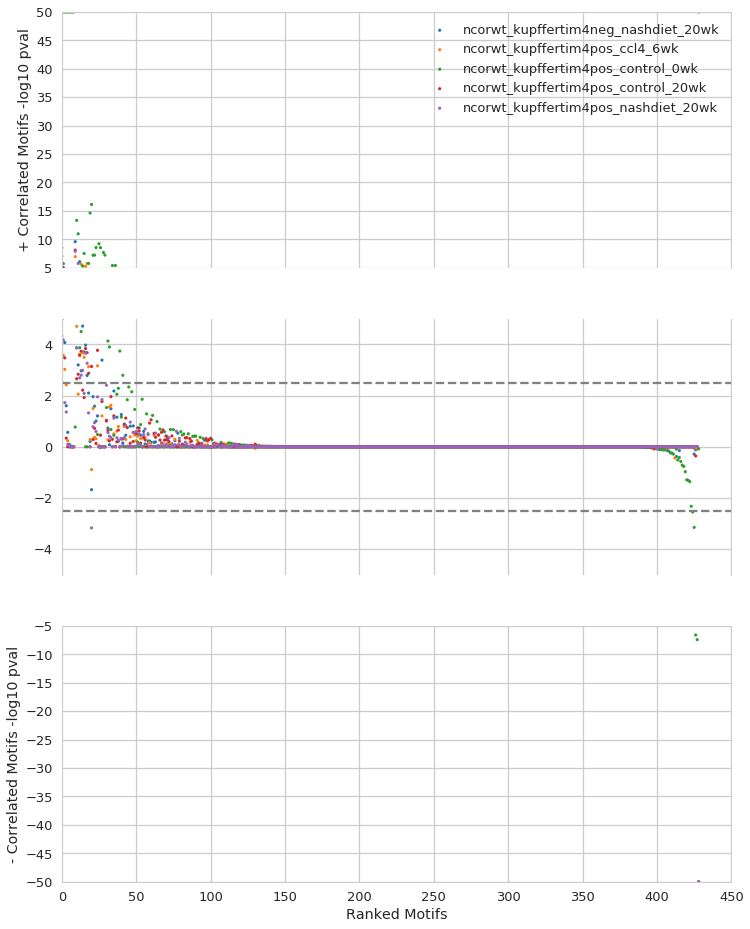

In [14]:
pseudocount = 1e-50 # set ceiling/floor for pvals
treatments = mean_pval_frame.columns
pval_threshold = 10**-2.5 # position of the dashed lines
treatment_orientedPvals_dict = {}
for treatment in treatments:
    pvals = mean_pval_frame[treatment]
    weights = mean_weights_frame[treatment]
    # calculate logpvals and assign direction according to weight
    oriented_pvals = [np.log10(x[0] +pseudocount) if x[1] < 0 else -np.log10(x[0]+pseudocount) for x in zip(pvals, weights)]
    treatment_orientedPvals_dict[treatment] = oriented_pvals

    # create data frame and sort according to mean
frame = pd.DataFrame(treatment_orientedPvals_dict, index = mean_pval_frame.index.values)
frame['mean'] = frame.mean(axis=1)
frame.sort_values('mean', ascending = False, inplace=True)
frame.drop('mean', axis=1, inplace=True)

colors = sns.color_palette()
counter = 0
with sns.axes_style('whitegrid'):
    # define subplots
    f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize = (12,16))

    for treatment in frame.columns.values:
        color = colors[counter]
        counter += 1
        # top panel
        # bottom panel
        ax1.scatter(list(range(frame.shape[0])), 
                    frame[treatment], 
                    label = treatment, 
                    c = color,
                    marker = 'o',
                    edgecolor = 'None',
                    s=10)
        
        # middle panel
        ax2.scatter(list(range(frame.shape[0])), 
                    frame[treatment], 
                    label = treatment, 
                    c = color,
                    marker = 'o',
                    edgecolor = 'None',
                    s=10)
        # bottom panel
        ax3.scatter(list(range(frame.shape[0])), 
                    frame[treatment], 
                    label = treatment, 
                    c = color,
                    marker = 'o',
                    edgecolor = 'None',
                    s=10)
        
    # scale panels
    plt.xlim(0,450)
    ax1.set_ylim(5, 50)
    ax2.set_ylim(-5, 5)  
    ax3.set_ylim(-50,-5)
    
    # hide the spines between axes
    ax1.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    
    ax2.spines['bottom'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    
    ax1.xaxis.tick_top()
    ax1.tick_params(labeltop='off')  # don't put tick labels at the top
    
    ax3.xaxis.tick_bottom()
    
    ax2.axhline(xmin=0,xmax=200,y=-np.log10(pval_threshold+ pseudocount), c='grey', linestyle='--')
    ax2.axhline(xmin=0,xmax=200,y=np.log10(pval_threshold+ pseudocount), c='grey', linestyle='--')
    
    ax1.set_ylabel('+ Correlated Motifs -log10 pval')
    ax3.set_ylabel('- Correlated Motifs -log10 pval')
    ax1.legend()
    
    plt.xlabel('Ranked Motifs')

    plt.savefig('./figures/tba_s_plot.pdf',bbox_inches='tight')

### Create Heatmap of Scores

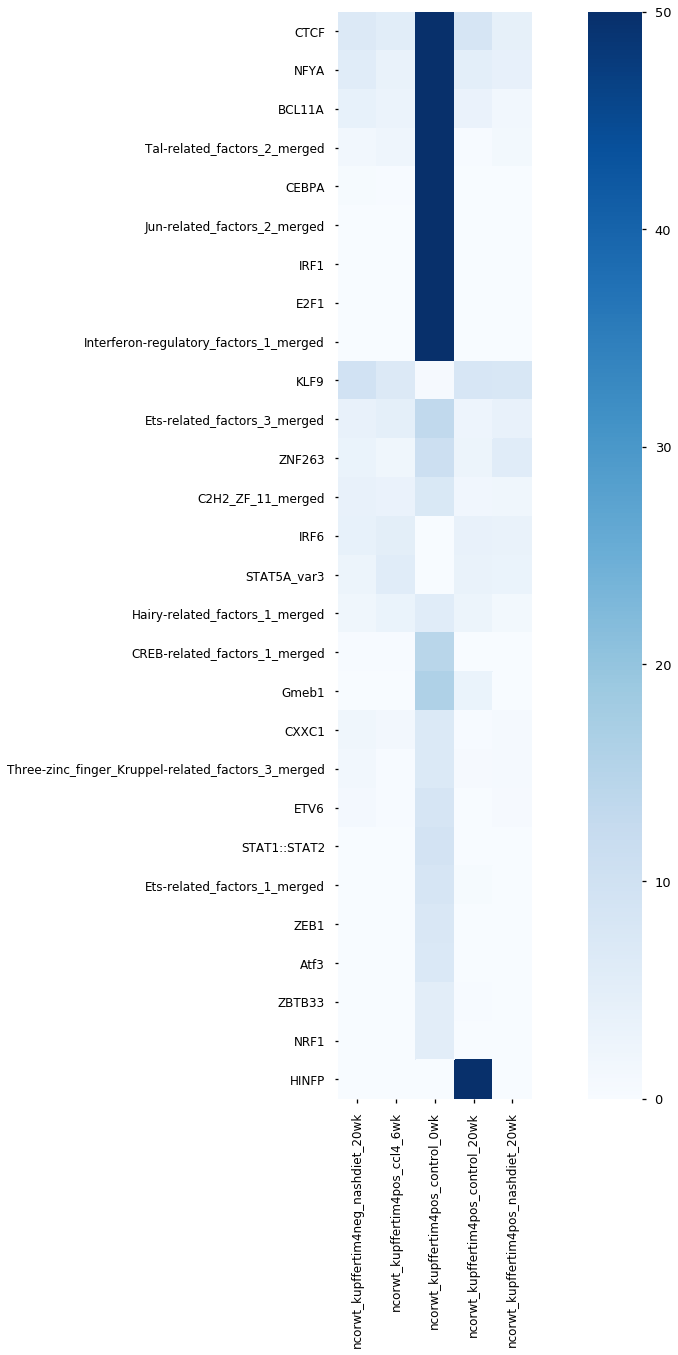

In [15]:
pseudocount = 1e-10 # pseudocount for calculating logfold change
treatments = mean_pval_frame.columns
# treatment_orientedPvals_dict = {}
for treatment in treatments:
    # retrieve pval and weights cooresponding to treatment
    pvals = mean_pval_frame[treatment]
    weights = mean_weights_frame[treatment]
    
    # calculate logpvals and assign direction according to weight
    oriented_pvals = [np.log10(x[0] +pseudocount) if x[1] < 0 else -np.log10(x[0]+pseudocount) for x in zip(pvals, weights)]

# create data frame
frame = pd.DataFrame(treatment_orientedPvals_dict, index = mean_pval_frame.index.values)
# sort by mean
frame['mean'] = frame.mean(axis=1)
frame.sort_values('mean', ascending = False, inplace=True)
frame.drop('mean', axis=1, inplace=True)

# plot only motifs with log pval > 2 for at least one condition (p<0.01) and positively correlated with open chromatin
frame = frame[frame.max(axis=1) > 2]
# plot only motifs with absolute log likelihood ratio >=4
filtered_frame = frame[((frame.max(axis=1) - frame.min(axis=1)).abs() >=4)]

# create heatmap
fig, ax = plt.subplots(figsize=(20,20))
hm = sns.heatmap(filtered_frame,
     vmin=0,
     cmap='Blues',
     square=True,
     ax=ax)
pos = hm.get_position()

hm.set_yticklabels(size=12, labels = filtered_frame.index.values[::-1]);
hm.set_xticklabels(size=12, labels = filtered_frame.columns.values, rotation=90);
plt.savefig('./figures/tba_heatmap.pdf',bbox_inches='tight')

In [30]:
corr_dict = {}
for file in os.listdir('./tba_output/'):
    if ('performance' in file) and ('combined' not in file):
        corr = pd.read_csv('./tba_output/' + file, squeeze=True)
        corr_dict[file] = corr

In [31]:
pd.DataFrame(corr_dict).mean(0)

ncorwt_kupffertim4neg_nashdiet_20wk_peaks_performance.tsv    0.394862
ncorwt_kupffertim4pos_ccl4_6wk_peaks_performance.tsv         0.390792
ncorwt_kupffertim4pos_control_0wk_peaks_performance.tsv      0.414947
ncorwt_kupffertim4pos_control_20wk_peaks_performance.tsv     0.369000
ncorwt_kupffertim4pos_nashdiet_20wk_peaks_performance.tsv    0.345029
dtype: float64

TypeError: <lambda>() missing 1 required positional argument: 'height'

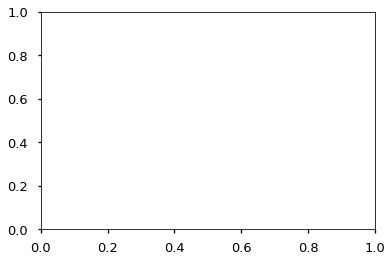

In [27]:
plt.barpd.DataFrame(corr_dict).mean(0))

# Repeat Analysis with Fold Changes 

### Merge All ATAC IDR Peaks

In [93]:
%%bash
if [ ! -d ./atac_merged/ ]; then mkdir ./atac_merged; fi
if [ ! -d ./tba_atac_merged/ ]; then mkdir ./tba_atac_merged; fi
# combine peaks
mergePeaks -d 100 ./atac_idr_peaks/*peaks.tsv > ./atac_merged/idr_peaks_merged.tsv
# annotate with h3k27ac signal
annotatePeaks.pl ./atac_merged/idr_peaks_merged.tsv mm10 -nogene -noann -d ./tag_directories_h3k27ac/* > idr_peaks_merged_ann.tsv
# use getDifferentialPeaks to get fold changes
# getDifferentialPeaks idr_peaks_merged_ann.tsv
# create bed file
pos2bed.pl ./atac_merged/idr_peaks_merged.tsv > ./atac_merged/idr_peaks_merged.bed
# extract sequence
/home/h1bennet/code/tba/model_training/extract_sequences_with_id.py ./atac_merged/idr_peaks_merged.bed mm10 ./atac_merged/idr_peaks_merged.fasta

reading genome mm10


	Max distance to merge: 100 bp
	Merging peaks... 
	Comparing ./atac_idr_peaks/ncorwt_kupffertim4neg_nashdiet_20wk_peaks.tsv (40741 total) and ./atac_idr_peaks/ncorwt_kupffertim4neg_nashdiet_20wk_peaks.tsv (40741 total)
	Comparing ./atac_idr_peaks/ncorwt_kupffertim4neg_nashdiet_20wk_peaks.tsv (40741 total) and ./atac_idr_peaks/ncorwt_kupffertim4pos_ccl4_6wk_peaks.tsv (29539 total)
	Comparing ./atac_idr_peaks/ncorwt_kupffertim4neg_nashdiet_20wk_peaks.tsv (40741 total) and ./atac_idr_peaks/ncorwt_kupffertim4pos_control_0wk_peaks.tsv (54773 total)
	Comparing ./atac_idr_peaks/ncorwt_kupffertim4neg_nashdiet_20wk_peaks.tsv (40741 total) and ./atac_idr_peaks/ncorwt_kupffertim4pos_control_20wk_peaks.tsv (32958 total)
	Comparing ./atac_idr_peaks/ncorwt_kupffertim4neg_nashdiet_20wk_peaks.tsv (40741 total) and ./atac_idr_peaks/ncorwt_kupffertim4pos_nashdiet_20wk_peaks.tsv (32811 total)
	Comparing ./atac_idr_peaks/ncorwt_kupffertim4pos_ccl4_6wk_peaks.tsv (29539 total) and ./atac_idr_peaks/ncorwt_ku

In [91]:
# get target positions
target_positions = read_target_positions(
    './atac_merged/idr_peaks_merged.bed',
    ['chrM', 'chrY'])

# calculate background positions
background_positions = get_random_background(
    target_positions,
    size_ratio=1.0, num_bins=10,
    n_threshold=0.1, genome='mm10')

# write out background positions - creates bed and fasta
background_positions_id = write_background_positions(
    background_positions,
    './atac_merged/')

# rename files
os.rename('./atac_merged/background.fasta',
          './atac_merged/'+bed.replace('.bed', '_background.fasta'))
os.rename('./atac_merged/background.bed',
          './atac_merged/'+bed.replace('.bed', '_background.bed'))

filtering out: chrM chrY
reading genome mm10
done reading genome
0 0
target GC: 0.3961042497220438 background GC: 0.39424917196111997 target length: 135 numTargetPositions 6731 backgroundPositions 6731
0 0
target GC: 0.44532086496666506 background GC: 0.4409186643012094 target length: 135 numTargetPositions 6731 backgroundPositions 6731
0 0
target GC: 0.47213217156956 background GC: 0.46533816319569843 target length: 135 numTargetPositions 6731 backgroundPositions 6731
0 0
target GC: 0.4937398153342212 background GC: 0.48552024434787183 target length: 135 numTargetPositions 6731 backgroundPositions 6731
0 0
target GC: 0.5134610759470247 background GC: 0.5055657755599088 target length: 135 numTargetPositions 6731 backgroundPositions 6731
0 0
target GC: 0.5338680674472743 background GC: 0.5238394347487346 target length: 135 numTargetPositions 6731 backgroundPositions 6731
0 0
target GC: 0.5575864490671372 background GC: 0.546137493773263 target length: 135 numTargetPositions 6731 backgro

In [94]:
# score all peaks
create_features('./atac_merged/idr_peaks_merged.fasta',
                './tba_atac_merged',
                '/home/h1bennet/code/tba/default_motifs/',
                num_processors=40)

computing features for all sequences
Ahr::Arnt calculation time: 11.161368131637573
Arid3a calculation time: 11.370743036270142
BBX calculation time: 10.48576307296753
ARNT::HIF1A calculation time: 12.823474884033203
C2H2_ZF_5_merged calculation time: 9.002856492996216
Atf3 calculation time: 12.88105821609497
ARID5B_var2 calculation time: 15.378919124603271
AHR_var2 calculation time: 16.342332363128662
Arid3b calculation time: 14.557219505310059
BARHL2 calculation time: 14.200819492340088
C2H2_ZF_12_merged calculation time: 12.537241220474243
C2H2_ZF_2_merged calculation time: 12.734785556793213
BACH1_var4 calculation time: 15.672464847564697
AP-2_1_merged calculation time: 18.11534810066223
ATF2_var2 calculation time: 18.606200218200684
ATF4 calculation time: 18.492525577545166
C2H2_ZF_3_merged calculation time: 14.261069059371948
BARX2 calculation time: 17.352370738983154
BATF::JUN calculation time: 17.01750111579895
Arid5a calculation time: 18.02421498298645
ARNT2 calculation time: 

IRF6 calculation time: 14.320337295532227
Homeodomain_8_merged calculation time: 19.66226816177368
Homeodomain_7_merged calculation time: 21.57353138923645
ISL1 calculation time: 13.747240543365479
KLF9 calculation time: 11.34036111831665
LIN54 calculation time: 9.023148536682129
Hoxd8 calculation time: 21.02960443496704
INSM1 calculation time: 20.627970933914185
Jun-related_factors_2_merged calculation time: 15.870074987411499
IRF4 calculation time: 20.36889362335205
MEIS1 calculation time: 9.794944286346436
LCOR calculation time: 13.175729990005493
IRF3 calculation time: 22.97382426261902
MAFG::NFE2L1 calculation time: 12.761936664581299
IRF5_var2 calculation time: 22.364154815673828
IRF4_var3 calculation time: 22.8601336479187
KLF8 calculation time: 18.9280948638916
KLF15 calculation time: 20.31207036972046
MXI1_var3 calculation time: 12.727536678314209
IRF7 calculation time: 24.023459911346436
IRF5_var3 calculation time: 24.547619581222534
MYF6 calculation time: 11.641116380691528


SOX18_var4 calculation time: 28.344448804855347
STAT_1_merged calculation time: 23.88558316230774
TERF2 calculation time: 9.41674280166626
Spz1 calculation time: 18.65411877632141
TAL1::TCF3 calculation time: 15.891749143600464
Sox_7_merged calculation time: 19.5758159160614
Six3 calculation time: 25.37225079536438
TBrain-related_factors_2_merged calculation time: 14.698771238327026
TBX2-related_factors_1_merged calculation time: 15.647159099578857
TBP calculation time: 15.956623077392578
TLX2 calculation time: 9.6759614944458
TEF-1-related_factors_1_merged calculation time: 14.207170724868774
Sox_3_merged calculation time: 22.961191415786743
TALE-type_homeo_domain_factors_1_merged calculation time: 17.722068548202515
STAT1::STAT2 calculation time: 28.883781909942627
TCF-7-related_factors_1_merged calculation time: 15.751709699630737
TALE-type_homeo_domain_factors_2_merged calculation time: 19.209816217422485
Sox_4_merged calculation time: 24.04395580291748
TBrain-related_factors_1_mer

### calculate fold changes - these will be the labels

In [17]:
tags = pd.read_csv('./atac_merged/idr_peaks_merged_ann.tsv', sep='\t', index_col=0)
tags.index.rename('peakID', inplace=True)

In [18]:
tim4pos_nash = pd.Series(tags.columns).str.contains('.*Tim4Pos.*nash.*', regex=True)
tim4neg_nash = pd.Series(tags.columns).str.contains('.*Tim4Pos.*Control.*', regex=True)
tim4pos_control = pd.Series(tags.columns).str.contains('.*Tim4Pos.*Control.*', regex=True)
tim4pos_ccl4 = pd.Series(tags.columns).str.contains('.*Tim4Pos.*CCl4.*', regex=True)

In [19]:
tim4pos_amln_fc = tags.loc[:, tim4pos_nash.values].mean(1) / (tags.loc[:, tim4pos_control.values].mean(1) + 1)
tim4neg_amln_fc = tags.loc[:, tim4neg_nash.values].mean(1) / (tags.loc[:, tim4pos_control.values].mean(1) + 1)
tim4pos_ccl4_fc = tags.loc[:, tim4pos_ccl4.values].mean(1) / (tags.loc[:, tim4pos_control.values].mean(1) + 1)

In [20]:
tim4pos_amln_fc.to_csv('./tba_atac_merged/tim4pos_amln_fc_labels.tsv', sep='\t')
tim4neg_amln_fc.to_csv('./tba_atac_merged/tim4neg_amln_fc_labels.tsv', sep='\t')
tim4pos_ccl4_fc.to_csv('./tba_atac_merged/tim4pos_ccl4_fc_labels.tsv', sep='\t')

### Scan Parameters Alpha

In [29]:
os.listdir('./tba_atac_merged/')

['tim4pos_ccl4_fc_coefficients.tsv',
 'tim4pos_amln_fc_performance.tsv',
 'tim4pos_ccl4_fc_significance.tsv',
 'tim4pos_ccl4_fc_performance.tsv',
 'tim4pos_amln_fc_coefficients.tsv',
 'tim4pos_amln_fc_significance.tsv',
 'tim4neg_amln_fc_significance.tsv',
 'tim4neg_amln_fc_coefficients.tsv',
 'idr_peaks_merged_motif_scores.tsv',
 'idr_peaks_merged_features.tsv',
 'tim4pos_amln_fc_labels.tsv',
 'tim4pos_ccl4_fc_labels.tsv',
 'tim4neg_amln_fc_labels.tsv',
 'idr_peaks_merged_motif_starts.tsv',
 'tim4neg_amln_fc_performance.tsv']

In [33]:
if not os.path.isdir('./tba_atac_merged_alpha_eval/'):
    os.mkdir('./tba_atac_merged_alpha_eval/')
fc = 'tim4pos_amln_fc_labels.tsv'
pearson = []
coef = []
print('assessing sample:', fc)
for alpha in np.arange(0, 1, 0.05):
    print('training model with alpha:', alpha)
    run_train_classifier('./tba_atac_merged/idr_peaks_merged_features.tsv',
                         './tba_atac_merged/' + fc,
                         output_path='./tba_atac_merged/',
                         num_iterations=3,
                         alpha=alpha)

    os.rename('./tba_atac_merged/idr_peaks_merged_significance.tsv',
              './tba_atac_merged_alpha_eval/' + fc.replace('labels', 'significance'))

    os.rename('./tba_atac_merged/idr_peaks_merged_performance.tsv',
              './tba_atac_merged_alpha_eval/' + fc.replace('labels', 'performance'))
    os.rename('./tba_atac_merged/idr_peaks_merged_coefficients.tsv',
              './tba_atac_merged_alpha_eval/' + fc.replace('labels', 'coefficients'))

assessing sample: tim4pos_amln_fc_labels.tsv
training model with alpha: 0.0
reading features and labels
training classifier for ./tba_atac_merged/idr_peaks_merged_features.tsv
training iteration: 1


/home/h1bennet/anaconda3/envs/tba/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=2.
  % (min_labels, self.n_folds)), Warning)


running f test
iteration training time: 16.058541774749756 pearson r 0.236508749905
training iteration: 2
running f test
iteration training time: 15.298060417175293 pearson r 0.238947288501
training iteration: 3
running f test
iteration training time: 16.227720975875854 pearson r 0.231283249603
Total time: 49.76170253753662
writing results
training model with alpha: 0.05
reading features and labels
training classifier for ./tba_atac_merged/idr_peaks_merged_features.tsv
training iteration: 1
running f test
iteration training time: 15.30421781539917 pearson r 0.240336000591
training iteration: 2
running f test
iteration training time: 14.40615177154541 pearson r 0.241565561305
training iteration: 3
running f test
iteration training time: 15.180947303771973 pearson r 0.242986796997
Total time: 46.82310175895691
writing results
training model with alpha: 0.1
reading features and labels
training classifier for ./tba_atac_merged/idr_peaks_merged_features.tsv
training iteration: 1
running f t

training classifier for ./tba_atac_merged/idr_peaks_merged_features.tsv
training iteration: 1
running f test
iteration training time: 16.261305570602417 pearson r 0.23988137701
training iteration: 2
running f test
iteration training time: 16.072800636291504 pearson r 0.238053490135
training iteration: 3
running f test
iteration training time: 15.415557146072388 pearson r 0.239944654178
Total time: 49.727224826812744
writing results
training model with alpha: 0.9
reading features and labels
training classifier for ./tba_atac_merged/idr_peaks_merged_features.tsv
training iteration: 1
running f test
iteration training time: 16.973182439804077 pearson r 0.233931036511
training iteration: 2
running f test
iteration training time: 15.703432559967041 pearson r 0.232413103375
training iteration: 3
running f test
iteration training time: 13.357443809509277 pearson r 0.232912920031
Total time: 47.816884994506836
writing results
training model with alpha: 0.95
reading features and labels
training

### Run the model

In [28]:
for fc in os.listdir('./tba_atac_merged/'):
    if 'labels' in fc:
        print('training model on:', fc)
        run_train_classifier('./tba_atac_merged/idr_peaks_merged_features.tsv',
                             './tba_atac_merged/' + fc,
                             output_path='./tba_atac_merged/',
                             num_iterations=1,
                             alpha=1)

        os.rename('./tba_atac_merged/idr_peaks_merged_significance.tsv',
                  './tba_atac_merged/' + fc.replace('labels', 'significance'))

        os.rename('./tba_atac_merged/idr_peaks_merged_performance.tsv',
                  './tba_atac_merged/' + fc.replace('labels', 'performance'))
        os.rename('./tba_atac_merged/idr_peaks_merged_coefficients.tsv',
                  './tba_atac_merged/' + fc.replace('labels', 'coefficients'))

training model on: tim4pos_amln_fc_labels.tsv
reading features and labels
training classifier for ./tba_atac_merged/idr_peaks_merged_features.tsv
training iteration: 1


/home/h1bennet/anaconda3/envs/tba/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=2.
  % (min_labels, self.n_folds)), Warning)


KeyboardInterrupt: 

### read in weight values

In [118]:
sample_weights_dict = {}
for f in os.listdir('./tba_atac_merged/'):
    if 'coefficients' in f and not 'gene' in f:
        # read in coefficients
        frame = pd.read_csv('./tba_atac_merged/' + f, sep='\t', index_col=0)
        # take the mean across cross validation iterations
        mean_weights = frame.mean(axis=1)
        sample = '_'.join(f.split('_')[0:4])
        sample_weights_dict[sample] = mean_weights
# create data frame
mean_weights_frame = pd.DataFrame(sample_weights_dict, index = sample_weights_dict[list(sample_weights_dict.keys())[0]].index.values)
mean_weights_frame = mean_weights_frame[mean_weights_frame.isnull().max(axis=1) ==False]

### read in significance values

In [119]:
sample_pval_dict = {}
for f in os.listdir('./tba_atac_merged/'):
    if 'significance' in f and not 'gene' in f:
        # read in signifance values using pandas
        frame = pd.read_csv('./tba_atac_merged/' + f, sep='\t', index_col=0)
        # take the mean across cross validation iterations
        mean_pval = frame.mean(axis=1) 
        sample = '_'.join(f.split('_')[0:4])
        sample_pval_dict[sample] = mean_pval
# create data frame
mean_pval_frame = pd.DataFrame(sample_pval_dict, index = sample_pval_dict[list(sample_pval_dict.keys())[0]].index.values)
mean_pval_frame = mean_pval_frame[mean_pval_frame.isnull().max(axis=1) ==False]

### Plot all Motifs Significance values

In [120]:
pseudocount = 1e-50 # set ceiling/floor for pvals
treatments = mean_pval_frame.columns
pval_threshold = 10**-2.5 # position of the dashed lines
treatment_orientedPvals_dict = {}
for treatment in treatments:
    pvals = mean_pval_frame[treatment]
    weights = mean_weights_frame[treatment]
    # calculate logpvals and assign direction according to weight
    oriented_pvals = [np.log10(x[0] +pseudocount) if x[1] < 0 else -np.log10(x[0]+pseudocount) for x in zip(pvals, weights)]
    treatment_orientedPvals_dict[treatment] = oriented_pvals

    # create data frame and sort according to mean
frame = pd.DataFrame(treatment_orientedPvals_dict, index = mean_pval_frame.index.values)
frame['mean'] = frame.mean(axis=1)
frame.sort_values('mean', ascending = False, inplace=True)
frame.drop('mean', axis=1, inplace=True)

colors = sns.color_palette()
counter = 0
with sns.axes_style('whitegrid'):
    # define subplots
    f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize = (12,16))

    for treatment in frame.columns.values:
        color = colors[counter]
        counter += 1
        # top panel
        # bottom panel
        ax1.scatter(list(range(frame.shape[0])), 
                    frame[treatment], 
                    label = treatment, 
                    c = color,
                    marker = 'o',
                    edgecolor = 'None',
                    s=10)
        
        # middle panel
        ax2.scatter(list(range(frame.shape[0])), 
                    frame[treatment], 
                    label = treatment, 
                    c = color,
                    marker = 'o',
                    edgecolor = 'None',
                    s=10)
        # bottom panel
        ax3.scatter(list(range(frame.shape[0])), 
                    frame[treatment], 
                    label = treatment, 
                    c = color,
                    marker = 'o',
                    edgecolor = 'None',
                    s=10)
        
    # scale panels
    plt.xlim(0,450)
    ax1.set_ylim(5, 50)
    ax2.set_ylim(-5, 5)  
    ax3.set_ylim(-50,-5)
    
    # hide the spines between axes
    ax1.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    
    ax2.spines['bottom'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    
    ax1.xaxis.tick_top()
    ax1.tick_params(labeltop='off')  # don't put tick labels at the top
    
    ax3.xaxis.tick_bottom()
    
    ax2.axhline(xmin=0,xmax=200,y=-np.log10(pval_threshold+ pseudocount), c='grey', linestyle='--')
    ax2.axhline(xmin=0,xmax=200,y=np.log10(pval_threshold+ pseudocount), c='grey', linestyle='--')
    
    ax1.set_ylabel('+ Correlated Motifs -log10 pval')
    ax3.set_ylabel('- Correlated Motifs -log10 pval')
    ax1.legend()
    
    plt.xlabel('Ranked Motifs')

    plt.savefig('./figures/tba_s_plot.pdf',bbox_inches='tight')

KeyError: 'tim4neg_amln_fc_significance.tsv'

### Create Heatmap of differential motifs

In [116]:
pseudocount = 1e-10 # pseudocount for calculating logfold change
treatments = mean_pval_frame.columns
# treatment_orientedPvals_dict = {}
for treatment in treatments:
    # retrieve pval and weights cooresponding to treatment
    pvals = mean_pval_frame[treatment]
    weights = mean_weights_frame[treatment]
    
    # calculate logpvals and assign direction according to weight
    oriented_pvals = [np.log10(x[0] +pseudocount) if x[1] < 0 else -np.log10(x[0]+pseudocount) for x in zip(pvals, weights)]

# create data frame
frame = pd.DataFrame(treatment_orientedPvals_dict, index = mean_pval_frame.index.values)
# sort by mean
frame['mean'] = frame.mean(axis=1)
frame.sort_values('mean', ascending = False, inplace=True)
frame.drop('mean', axis=1, inplace=True)

# plot only motifs with log pval > 2 for at least one condition (p<0.01) and positively correlated with open chromatin
frame = frame[frame.max(axis=1) > 2]
# plot only motifs with absolute log likelihood ratio >=4
filtered_frame = frame[((frame.max(axis=1) - frame.min(axis=1)).abs() >=4)]

# create heatmap
fig, ax = plt.subplots(figsize=(20,20))
hm = sns.heatmap(filtered_frame,
     vmin=0,
     cmap='Blues',
     square=True,
     ax=ax)
pos = hm.get_position()

hm.set_yticklabels(size=12, labels = filtered_frame.index.values[::-1]);
hm.set_xticklabels(size=12, labels = filtered_frame.columns.values, rotation=90);
plt.savefig('./figures/tba_heatmap.pdf',bbox_inches='tight')

KeyError: 'tim4neg_amln_fc_significance.tsv'

## Compare HOMER Results to TBA

### Run Get Differential Peaks

In [26]:
%%bash
# delete the existing script file
rm ./run_getDifferentialPeaks.sh
# create a script file
touch ./run_getDifferentialPeaks.sh

# if directories don't exist, create them
if [ ! -d ./diff_peaks/ ]; then mkdir ./diff_peaks; fi

In [27]:
import itertools
# write differential peaks and merge peaks commands
with open('./run_getDifferentialPeaks.sh', 'w') as f:
    # write differential peaks and merge peaks commands
    # merge peaks into one file
    f.write('mergePeaks -d 100 ./atac_idr_peaks/*peaks.tsv > ./atac_idr/ncorwt_atac_merged_peaks.tsv\n')
    # merge tag directories for getDifferential peaks
    mylist=rename_dict.keys()
    merged_peaks=[]
    for i, j in itertools.combinations(mylist, r=2):
        if (i.split('_ATAC')[0] == j.split('_ATAC')[0]):
            # create output file name for merging peaks
            out_file = [x for x in i.split('_') if x in set(j.split('_'))]
            out_file = '_'.join(out_file)+'_merged_tag_dir'
            merge_peaks = ['makeTagDirectory', './tag_directories_atac/'+out_file,
                           '-d', './tag_directories_atac/'+i,
                           './tag_directories_atac/'+j+'\n']
            f.write(' '.join(merge_peaks))
            merged_peaks.append(out_file)
            
    # run get differential peaks
    for i, j in itertools.combinations(merged_peaks, r=2):
        get_diff = ['getDifferentialPeaks', './atac_idr/ncorwt_atac_merged_peaks.tsv',
                    './tag_directories_atac/'+j, 
                    './tag_directories_atac/'+i, '>',
                    './diff_peaks/'+j+'_vs_'+i+'_diffpeaks.tsv\n']
        get_diff_rev = ['getDifferentialPeaks', './atac_idr/ncorwt_atac_merged_peaks.tsv',
                    './tag_directories_atac/'+i, 
                    './tag_directories_atac/'+j, '>',
                    './diff_peaks/'+i+'_vs_'+j+'_diffpeaks.tsv\n']
        f.write(' '.join(get_diff))
        f.write(' '.join(get_diff_rev))

In [28]:
# next up implement homer get differential motifs!

In [ ]:
findMotifsGenome.pl ./atac_idr_peaks_other/ncorwt_kupffertim4neg_nashdiet_21wk_peaks_distal.tsv mm10 ./find_motifs/ncorwt_kupffertim4pos_nashdiet_21wk_peaks_distal/ -size 200 -len 10,12,14

In [31]:
%%bash
# if directories don't exist, create them
if [ ! -d ./find_motifs/ ]; then mkdir ./find_motifs; fi

for diffpeak in ./atac_idr_peaks_other/*distal.tsv;
do echo findMotifsGenome.pl $diffpeak mm10 ./find_motifs/ -size 200 -len 10,12,14;
done

findMotifsGenome.pl ./atac_idr_peaks_other/ncorwt_bloodly6chi_controldiet_peaks_distal.tsv mm10 ./find_motifs/ -size 200 -len 10,12,14
findMotifsGenome.pl ./atac_idr_peaks_other/ncorwt_kupffertim4neg_nashdiet_21wk_peaks_distal.tsv mm10 ./find_motifs/ -size 200 -len 10,12,14
findMotifsGenome.pl ./atac_idr_peaks_other/ncorwt_kupffertim4pos_nashdiet_21wk_peaks_distal.tsv mm10 ./find_motifs/ -size 200 -len 10,12,14


### we can also try finding motifs with just the distal atac peak files

In [30]:
# # table this for now - can use to switch to doing homer on distal peaks only
# %%bash
# # get distal peaks since we are mainly interested in enhancers
# for peak_file in ./atac_idr_peaks/*;
# do dist_file=${peak_file/.tsv/_distal.tsv};
# echo $dist_file
# getDistalPeaks.pl $peak_file mm10 > $dist_file;
# done

### Process denovo motif results and read into data frame for analysis

In [41]:
import codecs
# p values stored at the 9 + 8n cells
# names of TFs stored at the 13 + 8n cells
denovo_results = {}
for homerfile in os.listdir('./find_motifs/'):
    tf_logp_dict = {}
    # open homer file
    if not homerfile.startswith('.'):
        f = codecs.open(
            './find_motifs/' + homerfile + '/homerResults.html', 'r')
        denovo = f.read().split('</TD><TD>')
        # table is in columns of 8
        # log p value is at position 9 + 8n
        # tf name is at position 13 + 8n
        for i in range(len(denovo) // 8):
            tf = denovo[13 + 8*i].split('/')[0]
            tf_2 = tf.split('(')[0]
            tf_logp_dict[tf_2] = denovo[9 + 8*i]
        denovo_results[homerfile] = tf_logp_dict
            
        
# create matrix of de novo motif log ps
denovo_logp = -pd.DataFrame(denovo_results, dtype=float).fillna(0)
# set max to 50 so its more comparable to tba
denovo_logp[denovo_logp > 50] = 50
# sort based on mean value
denovo_logp = denovo_logp.reindex(index=denovo_logp.mean(1).sort_values(ascending=False).index)

FileNotFoundError: [Errno 2] No such file or directory: './find_motifs/'

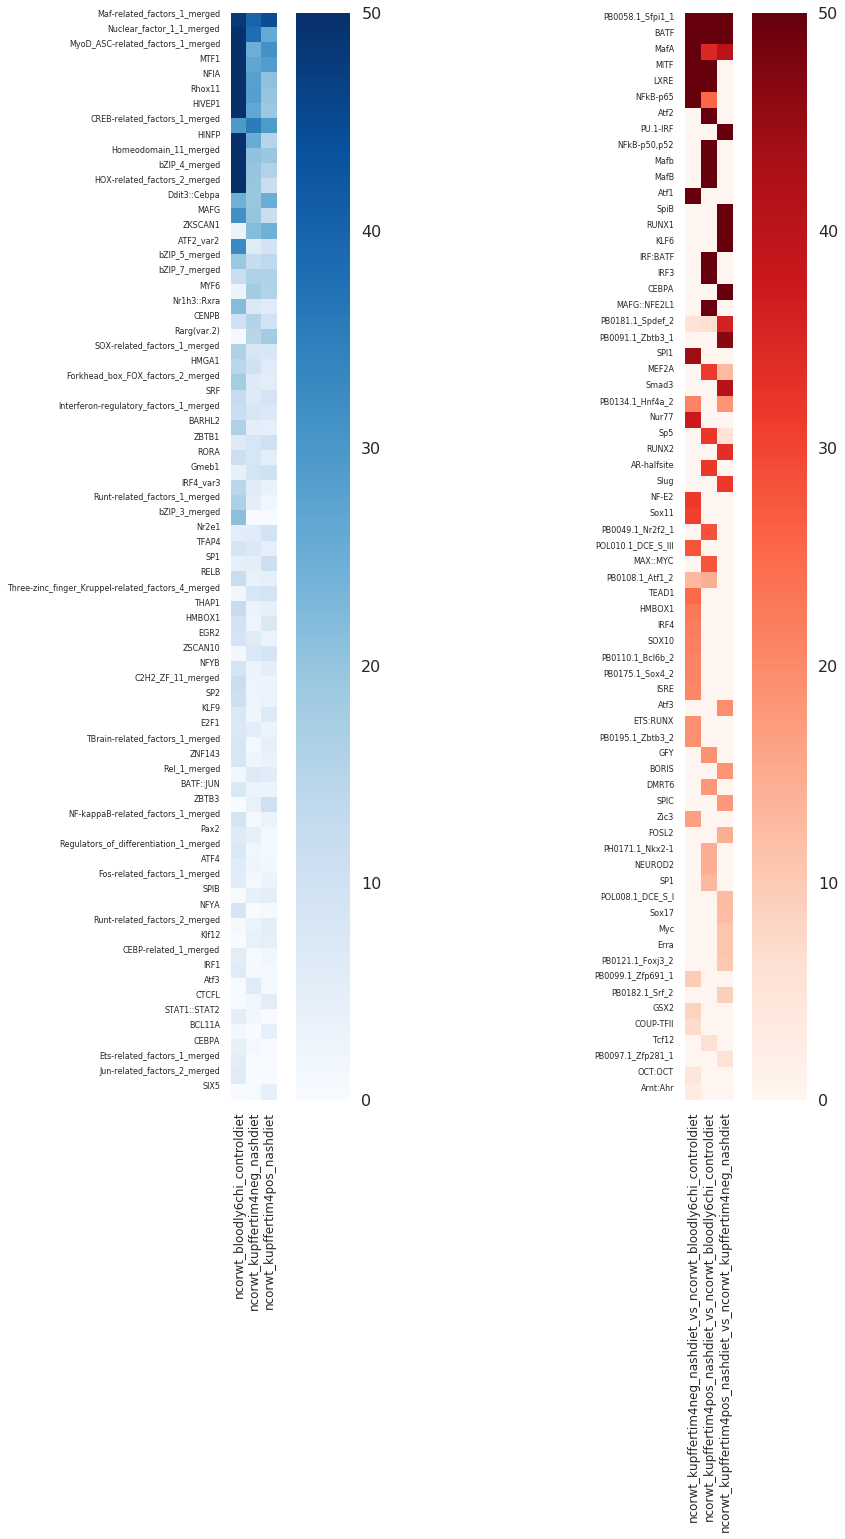

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,20), sharey=False)
hm = sns.heatmap(filtered_frame,
     vmin=0,
     cmap='Blues',
     square=True,
     ax=ax1)
pos = hm.get_position()

hm.set_yticks(range(0, filtered_frame.shape[0]));
hm.set_yticklabels(size=8, labels = filtered_frame.index.values[::-1]);
hm.set_xticklabels(size=12, labels = filtered_frame.columns.values, rotation=90);

hm2 = sns.heatmap(denovo_logp,
     vmin=0,
     cmap='Reds',
     square=True,
     ax=ax2)
pos = hm2.get_position()

hm2.set_yticks(range(0, denovo_logp.shape[0]));
hm2.set_yticklabels(size=8, labels = denovo_logp.index.values,
                    verticalalignment='top');
hm2.set_xticklabels(size=12, labels = denovo_logp.columns.values, rotation=90);

# Integrate RNA Seq Data

## Process RNA Seq Data

### RNA QC

In [27]:
%%bash
if [ ! -d ./qc_rna/ ]; then mkdir ./qc_rna; fi

In [28]:
# make summary table of qc stats
qc_stats = pd.DataFrame()

for sample in os.listdir('./tag_directories_rna/'):
    # pull tag information from HOMER output file
    tag_info_df = pd.read_table('./tag_directories_rna/'+sample+'/tagInfo.txt', sep='\t')
    qc_stats.loc[sample, 'uniquePositions'] = int(tag_info_df.iloc[0, 1])
    qc_stats.loc[sample, 'fragmentLengthEstimate'] = int(tag_info_df.iloc[1, 0].split('=')[1])
    qc_stats.loc[sample, 'tagsPerBP'] = float(tag_info_df.iloc[3, 0].split('=')[1])
    qc_stats.loc[sample, 'clonality'] = float(tag_info_df.iloc[4, 0].split('=')[1])
    qc_stats.loc[sample, 'GC_Content'] = float(tag_info_df.iloc[7, 0].split('=')[1])
    # f = open('./tag_directories_atac/'+sample+'/'+sample+'.mm10.bowtie2.log')
    # get mapping stats from bowtie log
    for file in os.listdir('./tag_directories_rna/'+sample+'/'):
        if file.endswith(".log"):
            f = open('./tag_directories_rna/'+sample+'/'+file)
            txt = f.read()
            star_log = list(filter(None, re.split('\s|\|',txt)))
            qc_stats.loc[sample, 'totalReads'] =int(star_log[29])
            qc_stats.loc[sample, 'uniquelyMappedReads'] = int(star_log[41])
            qc_stats.loc[sample, 'multiMappedReads'] = int(star_log[115])
            qc_stats.loc[sample, 'frac_unmappedReads_mismatch'] = float(star_log[151].strip('%'))/100
            qc_stats.loc[sample, 'frac_unmappedReads_short'] = float(star_log[158].strip('%'))/100
            qc_stats.loc[sample, 'frac_unmappedReads_other'] = float(star_log[164].strip('%'))/100
            qc_stats.loc[sample, 'uniquelyMappedFraction'] = \
                                                    qc_stats.loc[sample, 'uniquelyMappedReads'] \
                                                    / qc_stats.loc[sample, 'totalReads']
            qc_stats.loc[sample, 'mappedFraction'] = 1 \
                                            - qc_stats.loc[sample, 'frac_unmappedReads_other'] \
                                            - qc_stats.loc[sample, 'frac_unmappedReads_short'] \
                                            - qc_stats.loc[sample, 'totalReads']
    if not any(fname.endswith('.log') for fname in os.listdir('./tag_directories_rna/'+sample+'/')):
        print(sample + ' does not contain a mapping log file')
        qc_stats.loc[sample, 'totalReads'] = np.nan
        qc_stats.loc[sample, 'uniquelyMappedReads'] = np.nan
        qc_stats.loc[sample, 'multiMappedReads'] = np.nan
        qc_stats.loc[sample, 'frac_unmappedReads_mismatch'] = np.nan
        qc_stats.loc[sample, 'frac_unmappedReads_short'] = np.nan
        qc_stats.loc[sample, 'frac_unmappedReads_other'] = np.nan
        qc_stats.loc[sample, 'uniquelyMappedFraction'] = np.nan
        qc_stats.loc[sample, 'mappedFraction'] = np.nan

qc_stats.sort_index(inplace=True)
qc_stats.to_csv('./qc_rna/mapping_stats.tsv', sep='\t')

C57Bl6_KupfferTim4Pos_RNA_Control_0wk_NNaF does not contain a mapping log file
C57Bl6_KupfferTim4Pos_RNA_Control_0wk_LN12aM does not contain a mapping log file


### Annotate and Compile RNA

In [106]:
%%bash
# if directories don't exist, create them
if [ ! -d ./expression/ ]; then mkdir ./expression; fi

#analyzeRepeats.pl rna mm10 -count exons -condenseGenes -raw -d ./tag_directories_rna/* > ./expression/rna_exp_raw.tsv
#analyzeRepeats.pl rna mm10 -count exons -condenseGenes -d ./tag_directories_rna/* > ./expression/rna_exp.tsv
#analyzeRepeats.pl rna mm10 -count exons -condenseGenes -rpkm -d ./tag_directories_rna/* > ./expression/rna_exp_rpkm.tsv

	Tag Directories:
		./tag_directories_rna/C57B6J_Ly6cHi_RNA_NoTx_3
		./tag_directories_rna/C57B6J_Ly6cHi_RNA_NoTx_6and10
		./tag_directories_rna/C57B6J_Ly6cHi_RNA_NoTx_8
		./tag_directories_rna/C57Bl6_KupfferTim4Neg_RNA_AMLNDiet_20wk_LN200cM
		./tag_directories_rna/C57Bl6_KupfferTim4Neg_RNA_AMLNDiet_20wk_LN201cM
		./tag_directories_rna/C57Bl6_KupfferTim4Neg_RNA_AMLNDiet_20wk_LN203dM
		./tag_directories_rna/C57Bl6_KupfferTim4Pos_RNA_AMLNDiet_20wk_LN200cM
		./tag_directories_rna/C57Bl6_KupfferTim4Pos_RNA_AMLNDiet_20wk_LN201cM
		./tag_directories_rna/C57Bl6_KupfferTim4Pos_RNA_AMLNDiet_20wk_LN203dM
		./tag_directories_rna/C57Bl6_KupfferTim4Pos_RNA_CCl4_6wk_CC1B
		./tag_directories_rna/C57Bl6_KupfferTim4Pos_RNA_CCl4_6wk_CC1C
		./tag_directories_rna/C57Bl6_KupfferTim4Pos_RNA_CCl4_6wk_CC1D
		./tag_directories_rna/C57Bl6_KupfferTim4Pos_RNA_Control_0wk_LN12aM
		./tag_directories_rna/C57Bl6_KupfferTim4Pos_RNA_Control_0wk_NNaF
		./tag_directories_rna/C57Bl6_KupfferTim4Pos_RNA_Control_20wk_LN196cM

In [107]:
%%bash
#makeMultiWigHub.pl hrb_kupffer_21wk_rna mm10 -force -d ./tag_directories_rna/*


	Once finished, you will want to upload the following hub URL:
		http://homer.ucsd.edu/hubs//hrb_kupffer_21wk_rna/hub.txt

	If loading to the Wash U Epigenome Browser, use:
		http://homer.ucsd.edu/hubs//hrb_kupffer_21wk_rna/washU.hub.txt

	Overwriting contents in /homer_data/www/html/hubs//hrb_kupffer_21wk_rna

	Visualization fragment length = 75
	Output file: ./tag_directories_rna/C57B6J_Ly6cHi_RNA_NoTx_3/C57B6J_Ly6cHi_RNA_NoTx_3.ucsc.bigWig
	No need to remove tags to get desired file size
	Generating bedGraph for chr1
	Generating bedGraph for chr10
	Generating bedGraph for chr11
	Generating bedGraph for chr12
	Generating bedGraph for chr13
	Generating bedGraph for chr14
	Generating bedGraph for chr15
	Generating bedGraph for chr16
	Generating bedGraph for chr17
	Generating bedGraph for chr18
	Generating bedGraph for chr19
	Generating bedGraph for chr2
	Generating bedGraph for chr3
	Generating bedGraph for chr4
	Generating bedGraph for chr5
	Generating bedGraph for chr6
	Generating b

### RNA Data Wrangling
______
Goal is to get average expression of each transcription factor in dataset for each sample group

In [29]:
# import RNA Seq data
exp = pd.read_csv('./expression/rna_exp_rpkm.tsv', sep='\t', index_col=0)
exp.index.rename('refseq_id', inplace=True)
exp['gene'] = exp['Annotation/Divergence'].str.split('|').str[0]

# filter based on gene expression
exp_filt = ((exp.iloc[:, 7:-1] != 0).sum(1) == exp.shape[1]-8)
exp = exp.loc[exp_filt, :]

#filter based on length
exp = exp.loc[exp.Length >= 250, :]

# create average expression matrix
exp_avg = pd.DataFrame([exp.loc[:, list(pd.Series(exp.columns.values).str.contains('Control_0wk'))].mean(1),
                        exp.loc[:, list(pd.Series(exp.columns.values).str.contains('Control_20wk'))].mean(1),
                        exp.loc[:, list(pd.Series(exp.columns.values).str.contains('KupfferTim4Pos_RNA_AMLNDiet_20wk'))].mean(1),
                        exp.loc[:, list(pd.Series(exp.columns.values).str.contains('KupfferTim4Neg_RNA_AMLNDiet_20wk'))].mean(1),
                        exp.loc[:, list(pd.Series(exp.columns.values).str.contains('KupfferTim4Pos_RNA_CCl4_6wk'))].mean(1)],
                        index=['ncorwt_tim4pos_control_0wk', 'ncorwt_kupffertim4pos_control_20wk', 
                               'ncorwt_kupffertim4pos_nashdiet_20wks', 'ncorwt_kupffertim4neg_nashdiet_20wk',
                               'ncorwt_kupffertotal_ccl4_6wk']).T

# filter on average expression
avg_filt = (exp_avg > 10).any(1)
exp_avg = exp_avg.loc[avg_filt, :]

# import mm10 to refseq id gene mapper
mm10_refseq = pd.read_csv('/home/h1bennet/LXR/data/mm10_refseq_genename.txt',
                          sep='\t', names=['refseq_id', 'gene'],
                          index_col=0)
#merge to annotate dataset
exp_avg = exp_avg.merge(mm10_refseq, right_index=True,
              left_index=True, how='left')
# change index to gene name
exp_avg = exp_avg.set_index('gene')

# import jenhan's TF family to gene name file
motif_gene_dict = {}
with open('./motifGene_v2.txt') as f:
    for line in f:
        (key, val) = line.split()
        motif_gene_dict[key] = val

# convert motif/score frame to a tf/score frame
tf_score_dict = {}
for index, row in frame.iterrows():
    if index in motif_gene_dict.keys():
        for tf in re.split('\||::', motif_gene_dict[index]):
            tf_score_dict[tf.upper()] = row.values
            
tf_score_frame = pd.DataFrame(tf_score_dict, index=frame.columns).T

### Plot Data

In [43]:
# import linear regression module
import statsmodels.formula.api as sm

# define function for labeling points on scatter
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']), fontsize=12)

### tim4pos nash vs tim4pos 0wk control

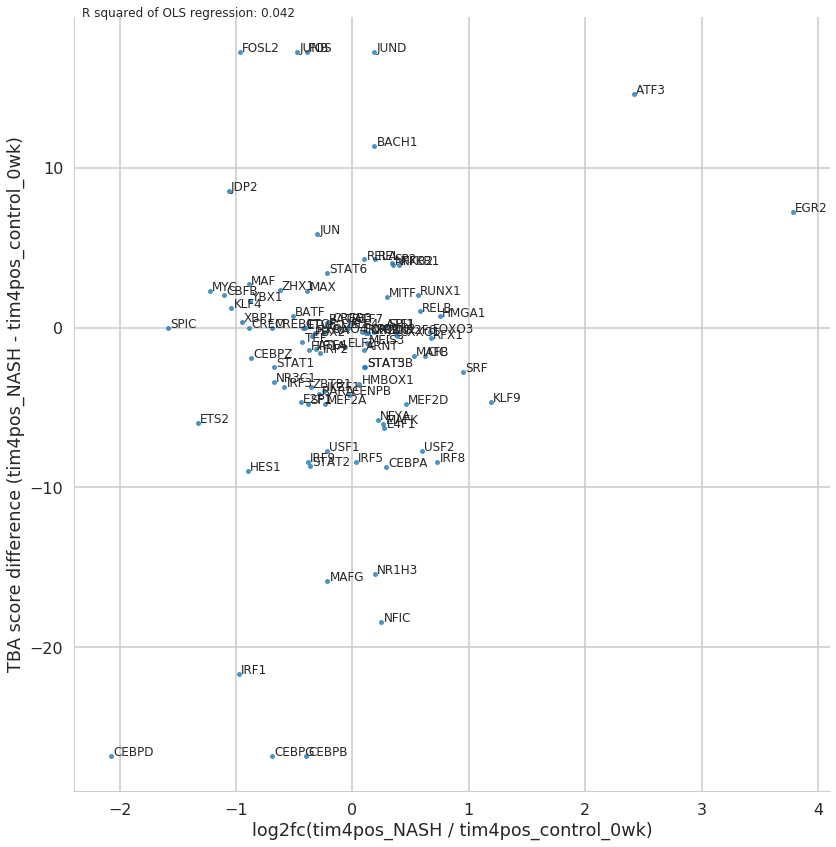

In [95]:
# create temporary frame with sample data
samp1 = 'ncorwt_kupffertim4pos_nashdiet_20wks'
samp2 = 'ncorwt_tim4pos_control_0wk'
avg_exp = (exp_avg[samp1] + exp_avg[samp2])/2
avg_exp.index = pd.Series(avg_exp.index).str.upper()
log2fc = np.log2(exp_avg[samp1] / exp_avg[samp2])
log2fc.index = pd.Series(log2fc.index).str.upper()
sig_delta = tf_score_frame[samp1] - tf_score_frame[samp2]
tmp_frame = pd.merge(pd.merge(pd.DataFrame(avg_exp, columns=['avg_exp']),
                              pd.DataFrame(log2fc, columns=['log2fc']),
                              right_index=True, left_index=True,
                              how='inner'),
                     pd.DataFrame(sig_delta, columns=['sig_delta']),
                     right_index=True, left_index=True,
                     how='inner')


# plot scatter
fig = sns.lmplot(x='log2fc', y='sig_delta',
                 data=tmp_frame, size=12,
                 scatter_kws={'s': 25},
                 fit_reg=False)
fig.set_axis_labels('log2fc(tim4pos_NASH / tim4pos_control_0wk)', 'TBA score difference (tim4pos_NASH - tim4pos_control_0wk)')
label_point(tmp_frame.log2fc, tmp_frame.sig_delta,
            pd.Series(tmp_frame.index, index=tmp_frame.index), plt.gca())

# calculate R^2
result = sm.ols(formula='sig_delta ~ log2fc', data=tmp_frame).fit()
plt.gca().annotate('R squared of OLS regression: %.3f' % result.rsquared,
             xy=(0.01, 1), xycoords='axes fraction', fontsize=12)

plt.savefig('./figures/tim4pos_nash_tim4pos_control_0wk_loglog_plot.pdf', bbox_inches='tight')

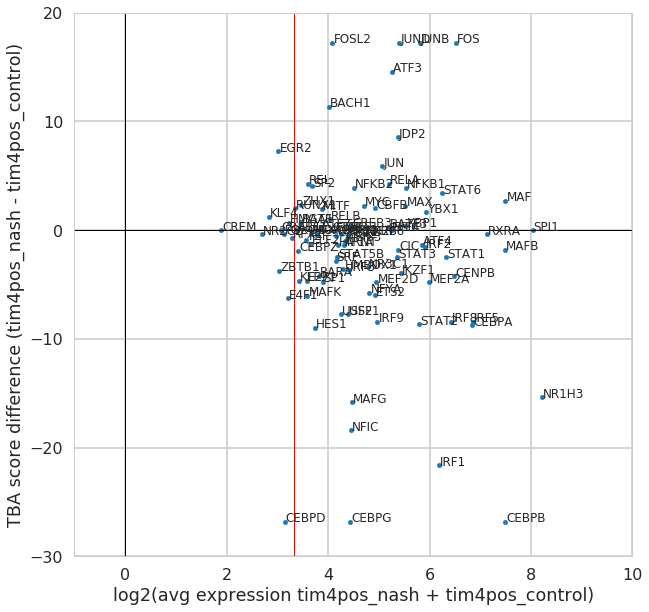

In [96]:
plt.figure(figsize=(10, 10))
plt.scatter(np.log2(tmp_frame.avg_exp),
            tmp_frame.sig_delta,
            s=20)
plt.xlabel('log2(avg expression tim4pos_nash + tim4pos_control)')
plt.ylabel('TBA score difference (tim4pos_nash - tim4pos_control)')

label_point(np.log2(tmp_frame.avg_exp), tmp_frame.sig_delta,
            pd.Series(tmp_frame.index, index=tmp_frame.index), plt.gca())

plt.plot([np.log2(10), np.log2(10)], [-100, 100], color='r', lw=1)
plt.plot([0, 0], [-100, 100], color='k', lw=1)
plt.plot([-100, 100], [0, 0], color='k', lw=1)
axes=plt.gca()
axes.set_xlim([-1,10])
axes.set_ylim([-30,20])

plt.savefig('./figures/tim4pos_nash_tim4pos_control_0wk_MAplot.pdf', bbox_inches='tight')

### tim4pos nash vs. tim4pos 20wk control

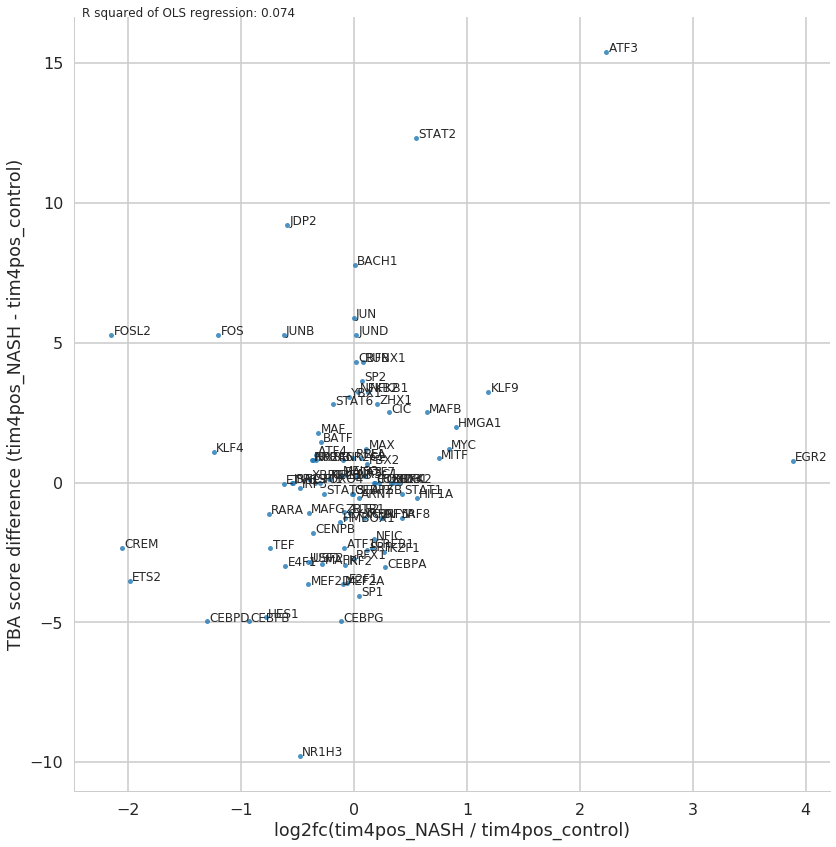

In [97]:
# create temporary frame with sample data
samp1 = 'ncorwt_kupffertim4pos_nashdiet_20wks'
samp2 = 'ncorwt_kupffertim4pos_control_20wk'
avg_exp = (exp_avg[samp1] + exp_avg[samp2])/2
avg_exp.index = pd.Series(avg_exp.index).str.upper()
log2fc = np.log2(exp_avg[samp1] / exp_avg[samp2])
log2fc.index = pd.Series(log2fc.index).str.upper()
sig_delta = tf_score_frame[samp1] - tf_score_frame[samp2]
tmp_frame = pd.merge(pd.merge(pd.DataFrame(avg_exp, columns=['avg_exp']),
                              pd.DataFrame(log2fc, columns=['log2fc']),
                              right_index=True, left_index=True,
                              how='inner'),
                     pd.DataFrame(sig_delta, columns=['sig_delta']),
                     right_index=True, left_index=True,
                     how='inner')


# plot scatter
fig = sns.lmplot(x='log2fc', y='sig_delta',
                 data=tmp_frame, size=12,
                 scatter_kws={'s': 25},
                 fit_reg=False)
fig.set_axis_labels('log2fc(tim4pos_NASH / tim4pos_control)', 'TBA score difference (tim4pos_NASH - tim4pos_control)')
label_point(tmp_frame.log2fc, tmp_frame.sig_delta,
            pd.Series(tmp_frame.index, index=tmp_frame.index), plt.gca())

# calculate R^2
result = sm.ols(formula='sig_delta ~ log2fc', data=tmp_frame).fit()
plt.gca().annotate('R squared of OLS regression: %.3f' % result.rsquared,
             xy=(0.01, 1), xycoords='axes fraction', fontsize=12)

plt.savefig('./figures/tim4pos_nash_tim4pos_control_20wk_loglog_plot.pdf', bbox_inches='tight')

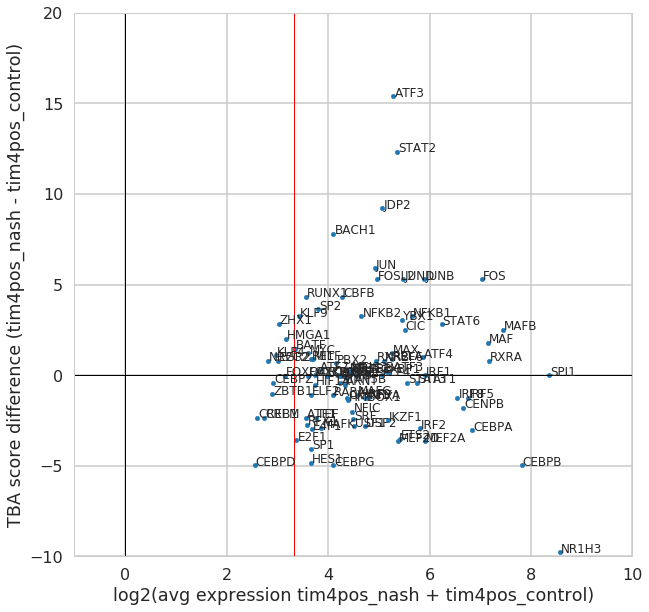

In [98]:
plt.figure(figsize=(10, 10))
plt.scatter(np.log2(tmp_frame.avg_exp),
            tmp_frame.sig_delta,
            s=20)
plt.xlabel('log2(avg expression tim4pos_nash + tim4pos_control)')
plt.ylabel('TBA score difference (tim4pos_nash - tim4pos_control)')

label_point(np.log2(tmp_frame.avg_exp), tmp_frame.sig_delta,
            pd.Series(tmp_frame.index, index=tmp_frame.index), plt.gca())

plt.plot([np.log2(10), np.log2(10)], [-100, 100], color='r', lw=1)
plt.plot([0, 0], [-100, 100], color='k', lw=1)
plt.plot([-100, 100], [0, 0], color='k', lw=1)
axes=plt.gca()
axes.set_xlim([-1,10])
axes.set_ylim([-10,20])

plt.savefig('./figures/tim4pos_nash_tim4pos_control_20wk_MAplot.pdf', bbox_inches='tight')

### Tim4Neg vs 0 wk control

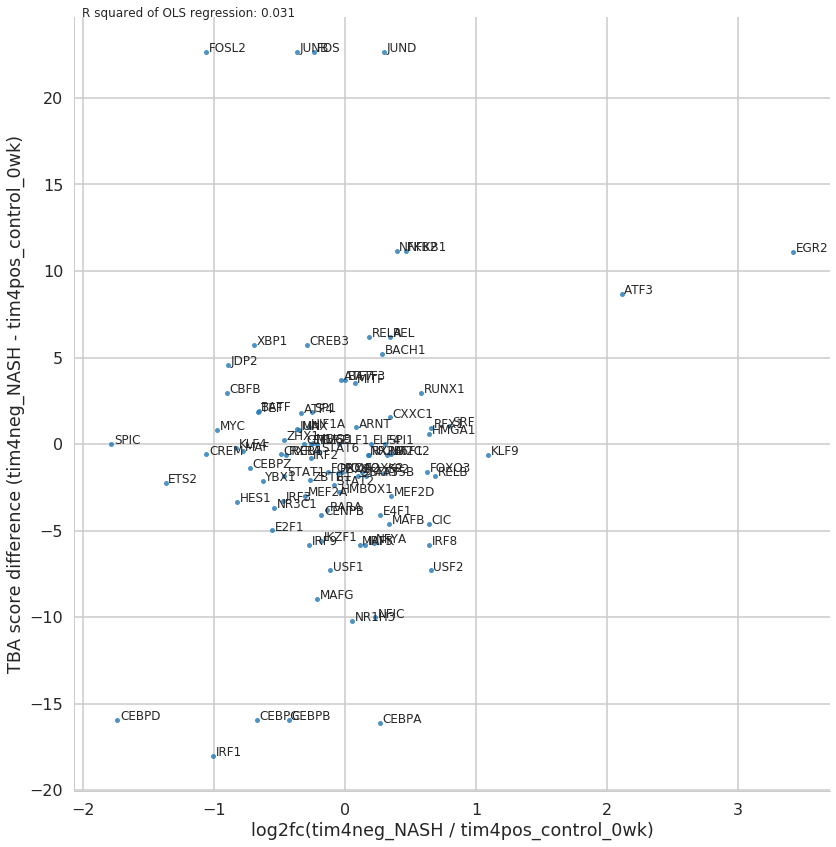

In [108]:
# create temporary frame with sample data
samp1 = 'ncorwt_kupffertim4neg_nashdiet_20wk'
samp2 = 'ncorwt_tim4pos_control_0wk'
avg_exp = (exp_avg[samp1] + exp_avg[samp2])/2
avg_exp.index = pd.Series(avg_exp.index).str.upper()
log2fc = np.log2(exp_avg[samp1] / exp_avg[samp2])
log2fc.index = pd.Series(log2fc.index).str.upper()
sig_delta = tf_score_frame[samp1] - tf_score_frame[samp2]
tmp_frame = pd.merge(pd.merge(pd.DataFrame(avg_exp, columns=['avg_exp']),
                              pd.DataFrame(log2fc, columns=['log2fc']),
                              right_index=True, left_index=True,
                              how='inner'),
                     pd.DataFrame(sig_delta, columns=['sig_delta']),
                     right_index=True, left_index=True,
                     how='inner')


# plot scatter
fig = sns.lmplot(x='log2fc', y='sig_delta',
                 data=tmp_frame, size=12,
                 scatter_kws={'s': 25},
                 fit_reg=False)
fig.set_axis_labels('log2fc(tim4neg_NASH / tim4pos_control_0wk)', 'TBA score difference (tim4neg_NASH - tim4pos_control_0wk)')
label_point(tmp_frame.log2fc, tmp_frame.sig_delta,
            pd.Series(tmp_frame.index, index=tmp_frame.index), plt.gca())

# calculate R^2
result = sm.ols(formula='sig_delta ~ log2fc', data=tmp_frame).fit()
plt.gca().annotate('R squared of OLS regression: %.3f' % result.rsquared,
             xy=(0.01, 1), xycoords='axes fraction', fontsize=12)

plt.savefig('./figures/tim4neg_nash_tim4pos_control_0wk_loglog_plot.pdf', bbox_inches='tight')

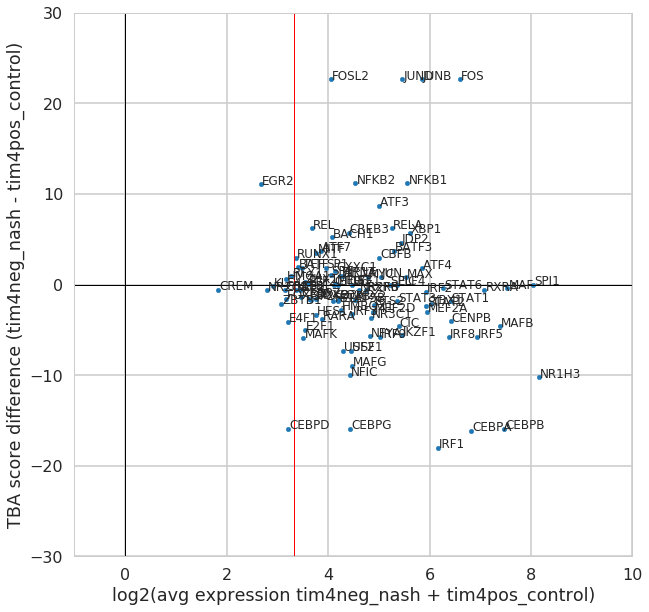

In [109]:
plt.figure(figsize=(10, 10))
plt.scatter(np.log2(tmp_frame.avg_exp),
            tmp_frame.sig_delta,
            s=20)
plt.xlabel('log2(avg expression tim4neg_nash + tim4pos_control)')
plt.ylabel('TBA score difference (tim4neg_nash - tim4pos_control)')

label_point(np.log2(tmp_frame.avg_exp), tmp_frame.sig_delta,
            pd.Series(tmp_frame.index, index=tmp_frame.index), plt.gca())

plt.plot([np.log2(10), np.log2(10)], [-100, 100], color='r', lw=1)
plt.plot([0, 0], [-100, 100], color='k', lw=1)
plt.plot([-100, 100], [0, 0], color='k', lw=1)
axes=plt.gca()
axes.set_xlim([-1,10])
axes.set_ylim([-30,30])

plt.savefig('./figures/tim4neg_nash_tim4pos_control_0wk_MAplot.pdf', bbox_inches='tight')

### Tim4Neg vs 20 wk control

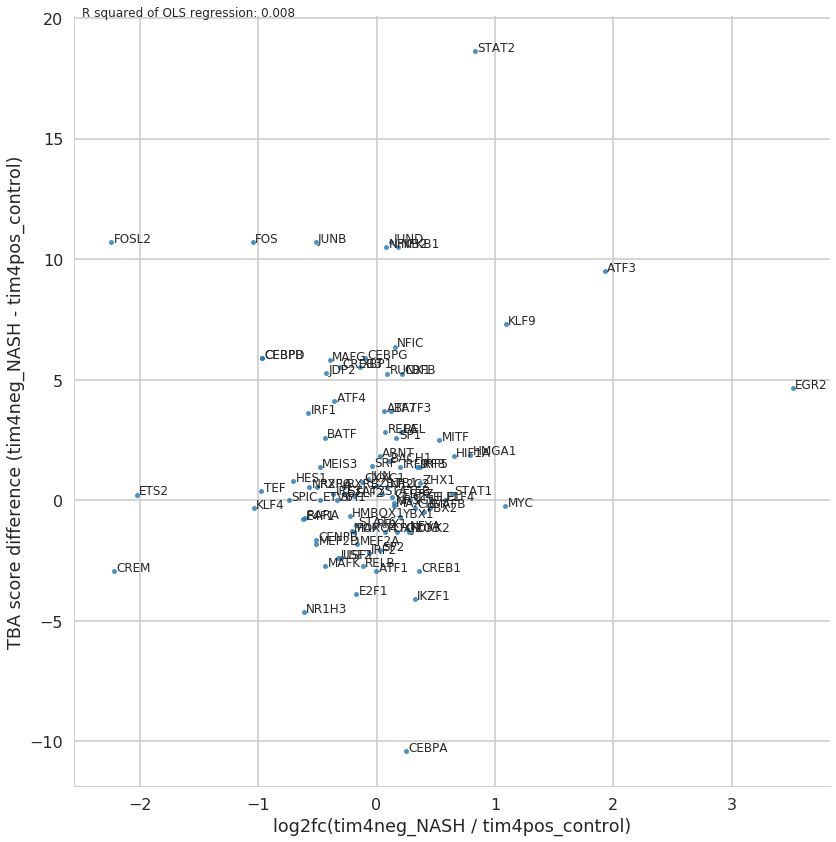

In [101]:
# create temporary frame with sample data
samp1 = 'ncorwt_kupffertim4neg_nashdiet_20wk'
samp2 = 'ncorwt_kupffertim4pos_control_20wk'
avg_exp = (exp_avg[samp1] + exp_avg[samp2])/2
avg_exp.index = pd.Series(avg_exp.index).str.upper()
log2fc = np.log2(exp_avg[samp1] / exp_avg[samp2])
log2fc.index = pd.Series(log2fc.index).str.upper()
sig_delta = tf_score_frame[samp1] - tf_score_frame[samp2]
tmp_frame = pd.merge(pd.merge(pd.DataFrame(avg_exp, columns=['avg_exp']),
                              pd.DataFrame(log2fc, columns=['log2fc']),
                              right_index=True, left_index=True,
                              how='inner'),
                     pd.DataFrame(sig_delta, columns=['sig_delta']),
                     right_index=True, left_index=True,
                     how='inner')


# plot scatter
fig = sns.lmplot(x='log2fc', y='sig_delta',
                 data=tmp_frame, size=12,
                 scatter_kws={'s': 25},
                 fit_reg=False)
fig.set_axis_labels('log2fc(tim4neg_NASH / tim4pos_control)', 'TBA score difference (tim4neg_NASH - tim4pos_control)')
label_point(tmp_frame.log2fc, tmp_frame.sig_delta,
            pd.Series(tmp_frame.index, index=tmp_frame.index), plt.gca())

# calculate R^2
result = sm.ols(formula='sig_delta ~ log2fc', data=tmp_frame).fit()
plt.gca().annotate('R squared of OLS regression: %.3f' % result.rsquared,
             xy=(0.01, 1), xycoords='axes fraction', fontsize=12)

plt.savefig('./figures/tim4neg_nash_tim4pos_control_20wk_loglog_plot.pdf', bbox_inches='tight')

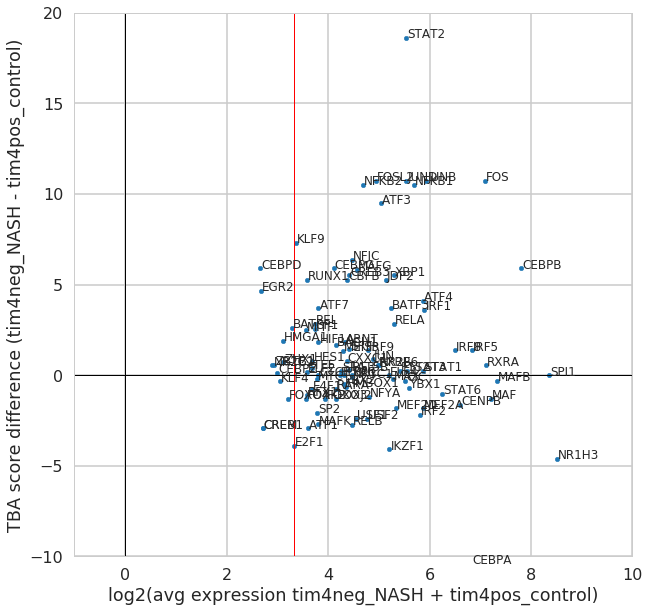

In [102]:
plt.figure(figsize=(10, 10))
plt.scatter(np.log2(tmp_frame.avg_exp),
            tmp_frame.sig_delta,
            s=20)
plt.xlabel('log2(avg expression tim4neg_NASH + tim4pos_control)')
plt.ylabel('TBA score difference (tim4neg_NASH - tim4pos_control)')

label_point(np.log2(tmp_frame.avg_exp), tmp_frame.sig_delta,
            pd.Series(tmp_frame.index, index=tmp_frame.index), plt.gca())

plt.plot([np.log2(10), np.log2(10)], [-100, 100], color='r', lw=1)
plt.plot([0, 0], [-100, 100], color='k', lw=1)
plt.plot([-100, 100], [0, 0], color='k', lw=1)
axes=plt.gca()
axes.set_xlim([-1,10])
axes.set_ylim([-10,20])

plt.savefig('./figures/tim4neg_nash_tim4pos_control_20wk_MAplot.pdf', bbox_inches='tight')

### CCl4 vs 0 wk control

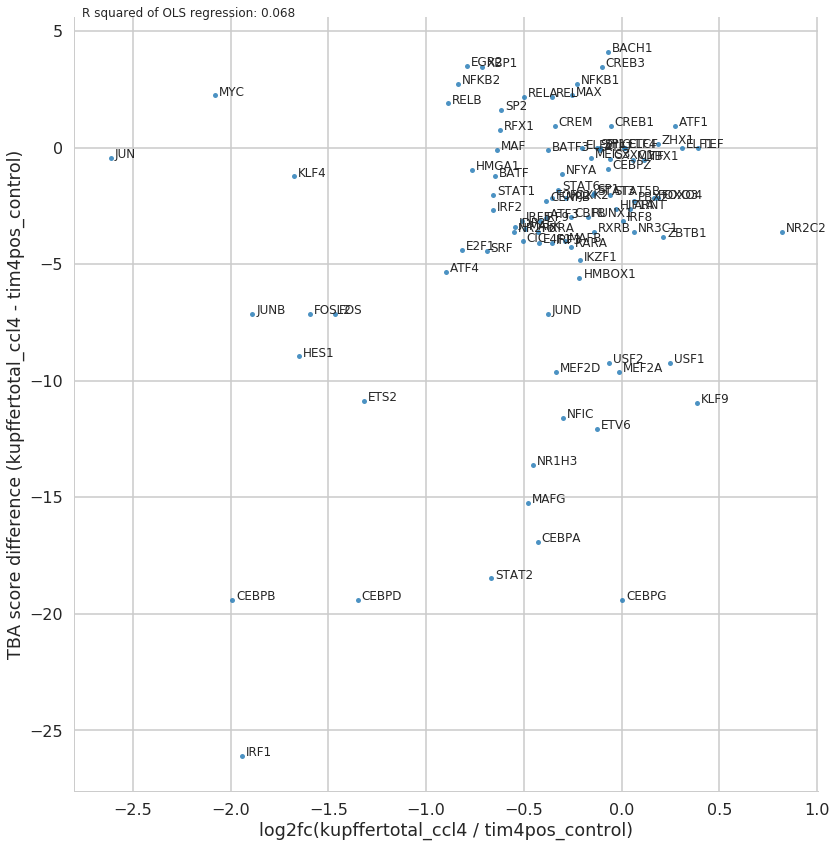

In [110]:
## create temporary frame with sample data
samp1 = 'ncorwt_kupffertotal_ccl4_6wk'
samp2 = 'ncorwt_tim4pos_control_0wk'
avg_exp = (exp_avg[samp1] + exp_avg[samp2])/2
avg_exp.index = pd.Series(avg_exp.index).str.upper()
log2fc = np.log2(exp_avg[samp1] / exp_avg[samp2])
log2fc.index = pd.Series(log2fc.index).str.upper()
sig_delta = tf_score_frame[samp1] - tf_score_frame[samp2]
tmp_frame = pd.merge(pd.merge(pd.DataFrame(avg_exp, columns=['avg_exp']),
                              pd.DataFrame(log2fc, columns=['log2fc']),
                              right_index=True, left_index=True,
                              how='inner'),
                     pd.DataFrame(sig_delta, columns=['sig_delta']),
                     right_index=True, left_index=True,
                     how='inner')


# plot scatter
fig = sns.lmplot(x='log2fc', y='sig_delta',
                 data=tmp_frame, size=12,
                 scatter_kws={'s': 25},
                 fit_reg=False)
fig.set_axis_labels('log2fc(kupffertotal_ccl4 / tim4pos_control)', 'TBA score difference (kupffertotal_ccl4 - tim4pos_control)')
label_point(tmp_frame.log2fc, tmp_frame.sig_delta,
            pd.Series(tmp_frame.index, index=tmp_frame.index), plt.gca())

# calculate R^2
result = sm.ols(formula='sig_delta ~ log2fc', data=tmp_frame).fit()
plt.gca().annotate('R squared of OLS regression: %.3f' % result.rsquared,
             xy=(0.01, 1), xycoords='axes fraction', fontsize=12)

plt.savefig('./figures/kupffertot_ccl4_vs_tim4pos_control_loglog_plot.pdf', bbox_inches='tight')

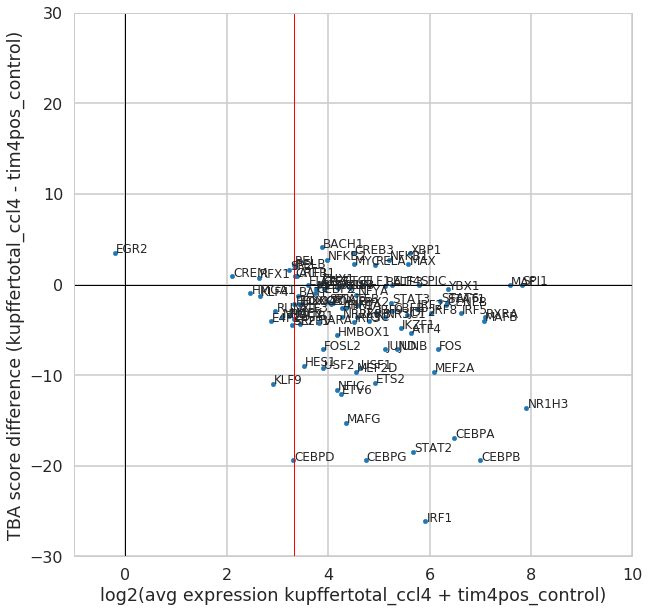

In [111]:
plt.figure(figsize=(10, 10))
plt.scatter(np.log2(tmp_frame.avg_exp),
            tmp_frame.sig_delta,
            s=20)
plt.xlabel('log2(avg expression kupffertotal_ccl4 + tim4pos_control)')
plt.ylabel('TBA score difference (kupffertotal_ccl4 - tim4pos_control)')

label_point(np.log2(tmp_frame.avg_exp), tmp_frame.sig_delta,
            pd.Series(tmp_frame.index, index=tmp_frame.index), plt.gca())

plt.plot([np.log2(10), np.log2(10)], [-100, 100], color='r', lw=1)
plt.plot([0, 0], [-100, 100], color='k', lw=1)
plt.plot([-100, 100], [0, 0], color='k', lw=1)
axes=plt.gca()
axes.set_xlim([-1,10])
axes.set_ylim([-30,30])

plt.savefig('./figures/kupffertot_ccl4_vs_tim4pos_control_MAplot.pdf', bbox_inches='tight')

### Tim4Pos AMLN vs Tim4Neg AMLN

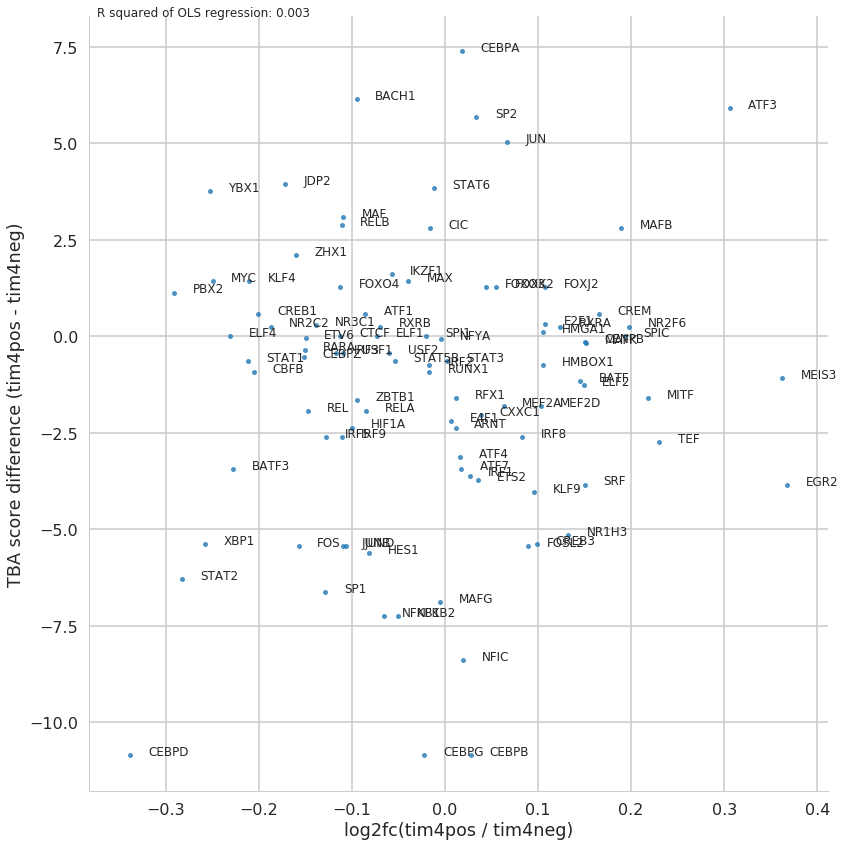

In [105]:
# create temporary frame with sample data
samp1 = 'ncorwt_kupffertim4pos_nashdiet_20wks'
samp2 = 'ncorwt_kupffertim4neg_nashdiet_20wk'
avg_exp = (exp_avg[samp1] + exp_avg[samp2])/2
avg_exp.index = pd.Series(avg_exp.index).str.upper()
log2fc = np.log2(exp_avg[samp1] / exp_avg[samp2])
log2fc.index = pd.Series(log2fc.index).str.upper()
sig_delta = tf_score_frame[samp1] - tf_score_frame[samp2]
tmp_frame = pd.merge(pd.merge(pd.DataFrame(avg_exp, columns=['avg_exp']),
                              pd.DataFrame(log2fc, columns=['log2fc']),
                              right_index=True, left_index=True,
                              how='inner'),
                     pd.DataFrame(sig_delta, columns=['sig_delta']),
                     right_index=True, left_index=True,
                     how='inner')


# plot scatter
fig = sns.lmplot(x='log2fc', y='sig_delta',
                 data=tmp_frame, size=12,
                 scatter_kws={'s': 25},
                 fit_reg=False)
fig.set_axis_labels('log2fc(tim4pos / tim4neg)', 'TBA score difference (tim4pos - tim4neg)')
label_point(tmp_frame.log2fc, tmp_frame.sig_delta,
            pd.Series(tmp_frame.index, index=tmp_frame.index), plt.gca())

# calculate R^2
result = sm.ols(formula='sig_delta ~ log2fc', data=tmp_frame).fit()
plt.gca().annotate('R squared of OLS regression: %.3f' % result.rsquared,
             xy=(0.01, 1), xycoords='axes fraction', fontsize=12)
plt.savefig('./expression/tim4pos_tim4neg_loglog_plot.pdf', bbox_inches='tight')

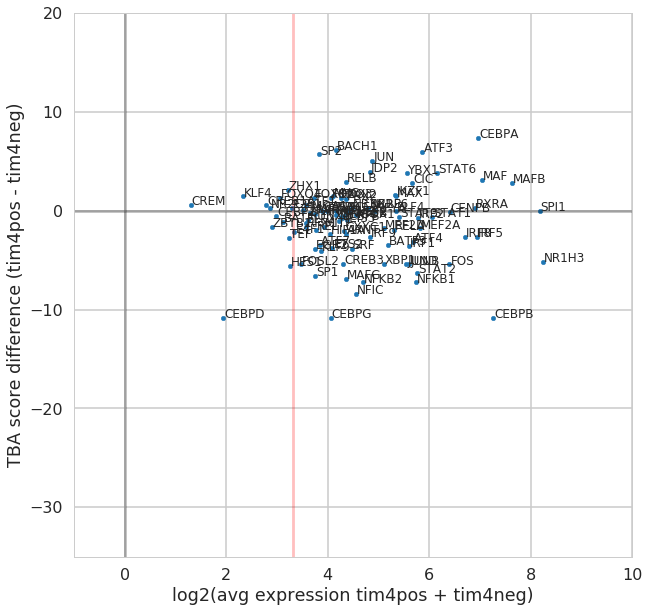

In [106]:
plt.figure(figsize=(10, 10))
plt.scatter(np.log2(tmp_frame.avg_exp),
            tmp_frame.sig_delta,
            s=20)
plt.xlabel('log2(avg expression tim4pos + tim4neg)')
plt.ylabel('TBA score difference (tim4pos - tim4neg)')

label_point(np.log2(tmp_frame.avg_exp), tmp_frame.sig_delta,
            pd.Series(tmp_frame.index, index=tmp_frame.index), plt.gca())

plt.plot([np.log2(10), np.log2(10)], [-100, 100], color='r', alpha=0.25)
plt.plot([0, 0], [-100, 100], color='k', alpha=0.25)
plt.plot([-100, 100], [0, 0], color='k', alpha=0.25)
axes=plt.gca()
axes.set_xlim([-1,10])
axes.set_ylim([-35,20])

plt.savefig('./expression/tim4pos_tim4neg_MAplot.pdf', bbox_inches='tight')

### Compare disease models?

### Create Table of top positively correlated motifs

In [377]:
pval_threshold = 1e-10
positive_motif_set = None
for treatment in treatments:
    pvals = mean_pval_frame[treatment]
    weights = mean_weights_frame[treatment]


    significant_positive_motifs = weights[weights>0].index.intersection(pvals[pvals < pval_threshold].index)
    if positive_motif_set == None:
        positive_motif_set = set(significant_positive_motifs)
    else:
        positive_motif_set = positive_motif_set.intersection(set(significant_positive_motifs)) 
data = mean_pval_frame.loc[sorted(positive_motif_set), :]

data = data+1e-50

positive_table = data[[]]
positive_table['Motif'] = data.index.values
positive_table['Mean p-val'] = data.mean(axis=1)
positive_table.sort_values(by='Mean p-val', inplace = True)
# positive_table.to_csv('./figures/postive_motif_table.tsv', sep='\t', index = False)
positive_table

/home/h1bennet/anaconda3/envs/tba/lib/python3.5/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/h1bennet/anaconda3/envs/tba/lib/python3.5/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/h1bennet/anaconda3/envs/tba/lib/python3.5/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

,Motif,Mean p-val
CTCF,CTCF,1.000000e-50
Klf12,Klf12,1.000000e-50
Ets-related_1_merged,Ets-related_1_merged,1.000000e-50
IRF1,IRF1,1.000000e-50
Ets-related_2_merged,Ets-related_2_merged,1.000001e-50
STAT1::STAT2,STAT1::STAT2,3.012751e-49
Atf3,Atf3,4.758546e-48
Gabpa,Gabpa,1.042895e-47
NFYA,NFYA,4.740630e-30
Pax2,Pax2,2.150195e-29
